In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import optuna
from sklearn.model_selection import train_test_split, KFold
from optuna.samplers import TPESampler
from optuna import Trial
from xgboost import XGBRegressor

In [2]:
path = 'data/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [3]:
train.head()

,quarter,department,day,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,Quarter1,sweing,Thursday,0.80,26.16,1108,0.27315,98,0,0,0,59,0.94073
1,Quarter1,finishing,Thursday,0.75,3.94,1190,0.03704,0,0,0,0,8,0.88650
2,Quarter1,sweing,Thursday,0.80,11.41,968,0.14120,50,0,0,0,30,0.80057
3,Quarter1,sweing,Thursday,0.80,11.41,968,0.14120,50,0,0,0,30,0.80057
4,Quarter1,sweing,Thursday,0.80,25.90,1170,0.07407,50,0,0,0,56,0.80038


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   targeted_productivity  1197 non-null   float64
 4   smv                    1197 non-null   float64
 5   wip                    1197 non-null   int64  
 6   over_time              1197 non-null   float64
 7   incentive              1197 non-null   int64  
 8   idle_time              1197 non-null   int64  
 9   idle_men               1197 non-null   int64  
 10  no_of_style_change     1197 non-null   int64  
 11  no_of_workers          1197 non-null   int64  
 12  actual_productivity    1197 non-null   float64
dtypes: float64(4), int64(6), object(3)
memory usage: 121.7+ KB


In [5]:
train.shape

(1197, 13)

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                818 non-null    object 
 1   department             818 non-null    object 
 2   day                    818 non-null    object 
 3   targeted_productivity  818 non-null    float64
 4   smv                    818 non-null    float64
 5   wip                    818 non-null    int64  
 6   over_time              818 non-null    float64
 7   incentive              818 non-null    int64  
 8   idle_time              818 non-null    int64  
 9   idle_men               818 non-null    int64  
 10  no_of_style_change     818 non-null    int64  
 11  no_of_workers          818 non-null    int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 76.8+ KB


In [7]:
test.shape

(818, 12)

In [8]:
train.describe()

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,0.729632,15.062172,1190.269006,0.176214,38.210526,0.727652,0.369256,0.150376,34.551378,0.735091
std,0.097891,10.943219,1395.647280,0.129197,160.182643,12.709094,3.268987,0.427848,22.152559,0.174488
min,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233710
25%,0.700000,3.940000,970.000000,0.055560,0.000000,0.000000,0.000000,0.000000,9.000000,0.650310
50%,0.750000,15.260000,1190.000000,0.152780,0.000000,0.000000,0.000000,0.000000,34.000000,0.773330
75%,0.800000,24.260000,1190.000000,0.268520,50.000000,0.000000,0.000000,0.000000,57.000000,0.850250
max,0.800000,54.560000,23122.000000,1.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120440


In [9]:
column_info = pd.read_csv(path+'column_info.csv')
column_info.values

array([['ID', '샘플 ID'],
       ['quarter', '한 달을 4개의 기간으로 분할한 단위 (예시: 1주차, 2주차, 3주차 ..)'],
       ['department', '인스턴스 관련 부서'],
       ['day', '요일'],
       ['targeted_productivity', '설정한 목표 생산성'],
       ['smv', '작업에 할당된 시간 (분)'],
       ['wip', '작업 진행 중인 품목 수 (제품에 대한 미완성 품목 수 포함)'],
       ['over_time', '각 팀별 초과 근무 정도 (0~1)'],
       ['incentive', '재정적 인센티브 양 (BDT 단위)'],
       ['idle_time', '생산이 중단된 시간'],
       ['idle_men', '생산 중단으로 유휴인원 수'],
       ['no_of_style_change', '특정 제품의 스타일 변경 횟수'],
       ['no_of_workers', '팀별 작업자 수'],
       ['actual_productivity', '생산량 (target)']], dtype=object)

In [10]:
train['quarter'].describe()

count         1197
unique           5
top       Quarter1
freq           360
Name: quarter, dtype: object

In [11]:
train['quarter'].value_counts()

Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: quarter, dtype: int64

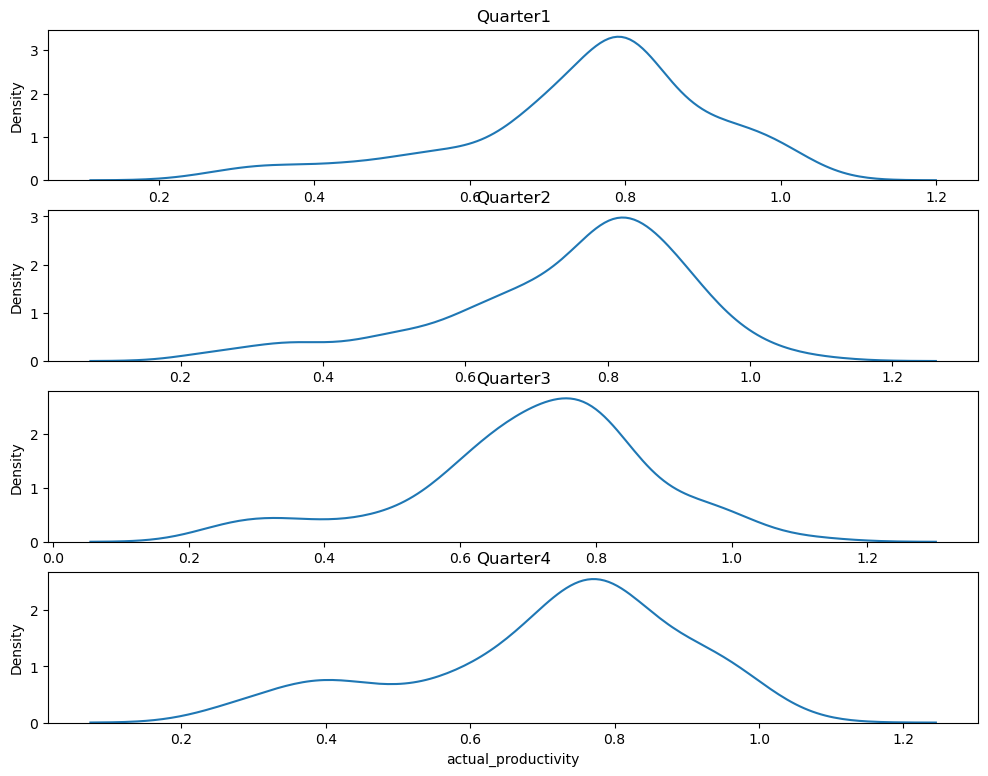

In [12]:
f, ax = plt.subplots(4, 1, figsize=(12,9))

for i in range(1,5):
    feat_name = 'Quarter'+str(i)
    sns.kdeplot(data=train[train['quarter'] == feat_name], x='actual_productivity', ax=ax[i-1])
    ax[i-1].set_title(feat_name)

Text(0.5, 1.0, 'Quarter')

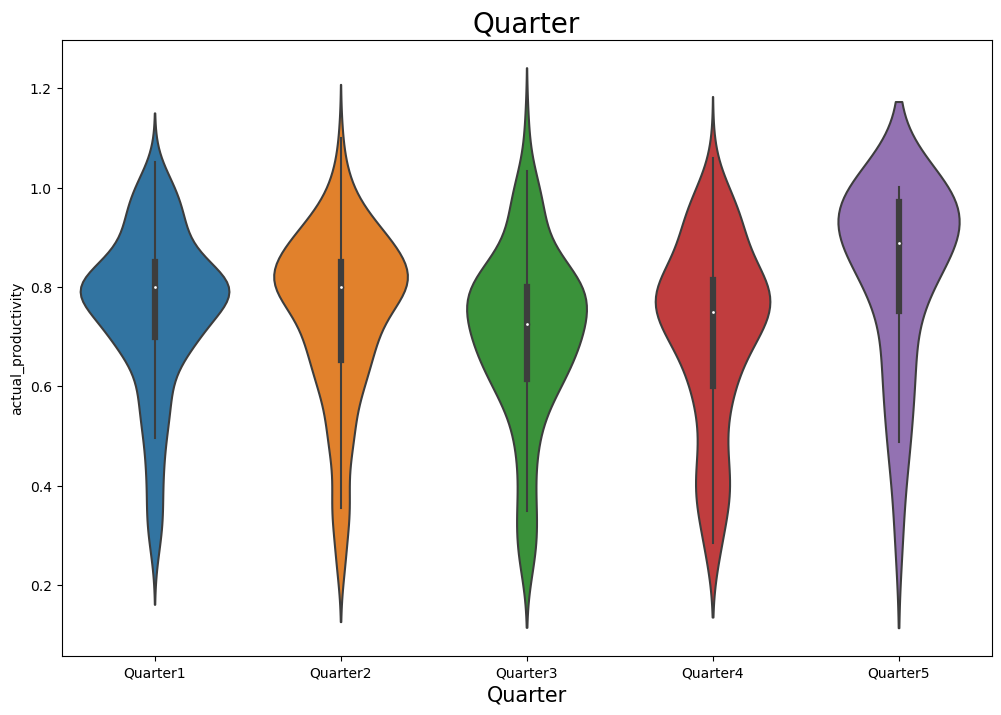

In [13]:
plt.figure(figsize=(12,8))
sns.violinplot(data=train, y='actual_productivity', x='quarter')
plt.xlabel('Quarter', fontsize=15)
plt.title('Quarter', fontsize=20)

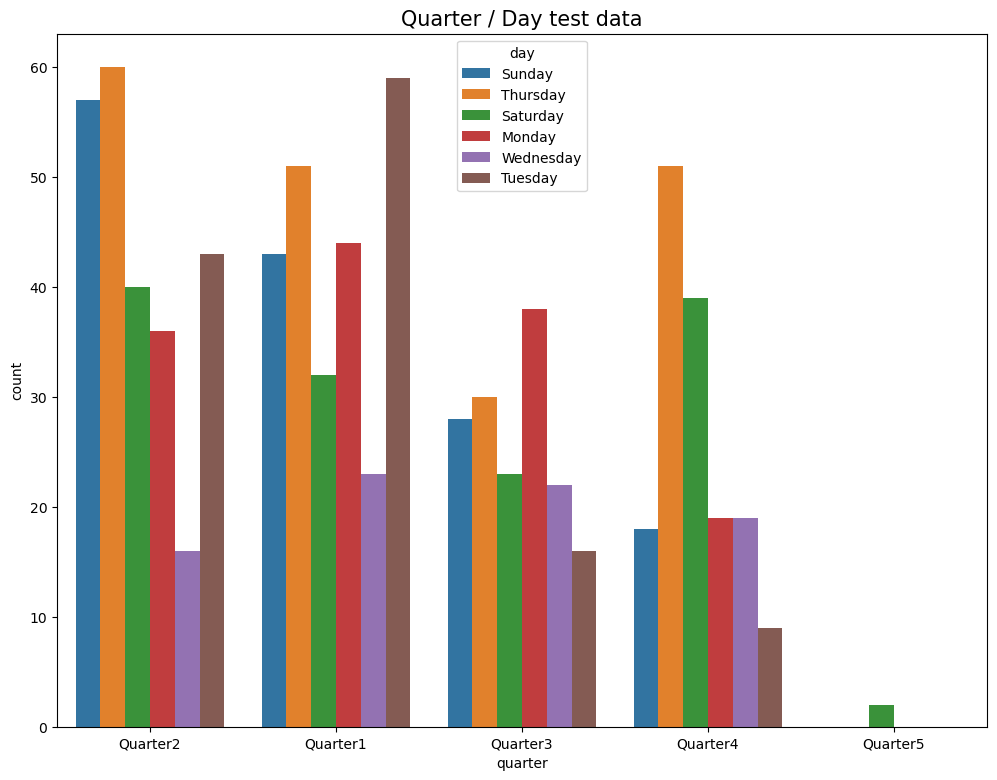

In [14]:
plt.figure(figsize=(12,9))
sns.countplot(data=test, x='quarter', hue='day')
plt.title('Quarter / Day test data', fontsize=15)
plt.show()

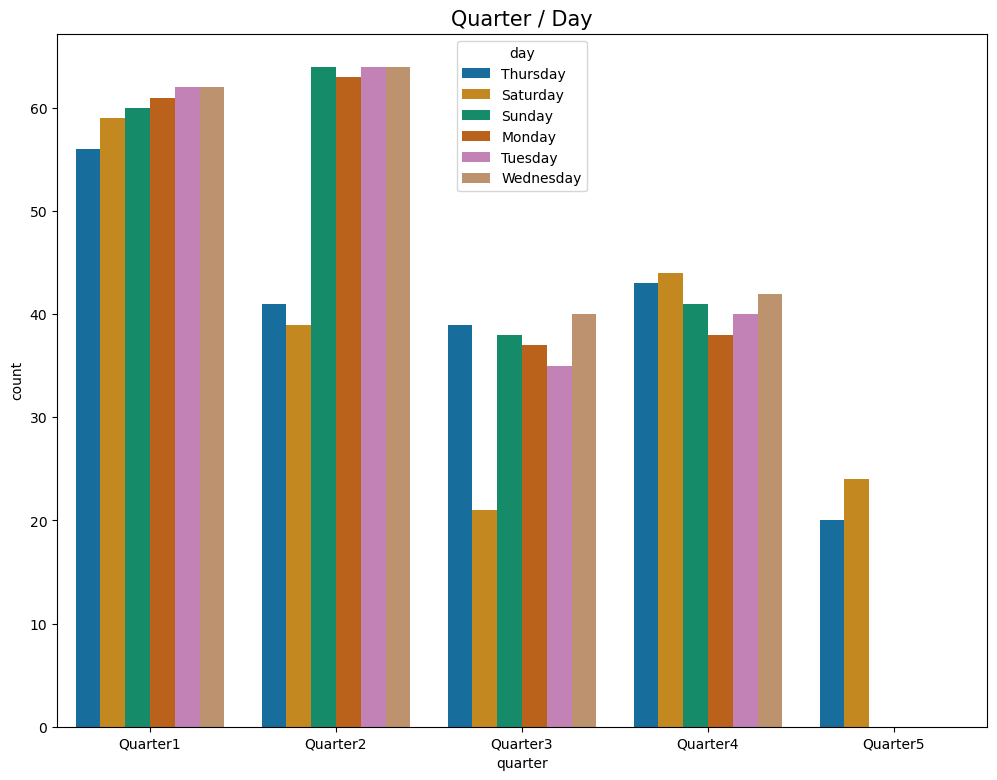

In [15]:
plate3 = sns.color_palette('colorblind', n_colors=6)
plt.figure(figsize=(12,9))
sns.countplot(data=train, x='quarter', hue='day', palette=plate3)
plt.title('Quarter / Day', fontsize=15)
plt.show()

In [16]:
train_quarter_encoding = {'Quarter1':0, 'Quarter2':0, 'Quarter3':1, 'Quarter4':1, 'Quarter5':2}
train['quarter'] = train['quarter'].map(train_quarter_encoding)
test['quarter'] = test['quarter'].map(train_quarter_encoding)
train['quarter'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: quarter, dtype: int64

In [17]:
dat_encoding = {'Thursday':0,'Saturday':0,'Sunday':1, 'Monday':2, 'Tuesday':3, 'Wednesday':3 }

train['day'] = train['day'].map(dat_encoding)
test['day'] = test['day'].map(dat_encoding)

In [21]:
train['targeted_productivity'].describe()

count    1197.000000
mean        0.729632
std         0.097891
min         0.070000
25%         0.700000
50%         0.750000
75%         0.800000
max         0.800000
Name: targeted_productivity, dtype: float64

In [19]:
train[train['targeted_productivity']==0.07]

,quarter,department,day,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
633,0,sweing,0,0.07,24.26,1608,0.26852,0,0,0,0,58,0.52284


In [24]:
train[(train['actual_productivity']>=0.5) & (train['actual_productivity'] < 0.6)].targeted_productivity.median()

0.7

In [25]:
train.loc[train['targeted_productivity']==0.07, 'targeted_productivity']=0.7

In [27]:
test.head()

,quarter,department,day,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
0,0,sweing,1,0.58792,37.82119,732,0.39583,7,0,0,0,57
1,0,sweing,1,0.70000,37.88145,710,0.35666,0,0,0,0,57
2,0,sweing,0,0.63145,38.49087,722,0.39515,4,0,0,0,56
3,0,sweing,1,0.61823,39.06224,729,0.39583,5,0,0,0,57
4,0,finishing,1,0.64060,3.91624,1190,0.04456,0,0,0,0,8


In [28]:
train['targeted_productivity'] *= 100
train.head()

,quarter,department,day,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,0,sweing,0,80.0,26.16,1108,0.27315,98,0,0,0,59,0.94073
1,0,finishing,0,75.0,3.94,1190,0.03704,0,0,0,0,8,0.88650
2,0,sweing,0,80.0,11.41,968,0.14120,50,0,0,0,30,0.80057
3,0,sweing,0,80.0,11.41,968,0.14120,50,0,0,0,30,0.80057
4,0,sweing,0,80.0,25.90,1170,0.07407,50,0,0,0,56,0.80038


In [30]:
test['targeted_productivity'] = test['targeted_productivity'].round(2)
test['targeted_productivity'] *= 100
test.head()

,quarter,department,day,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
0,0,sweing,1,59.0,37.82119,732,0.39583,7,0,0,0,57
1,0,sweing,1,70.0,37.88145,710,0.35666,0,0,0,0,57
2,0,sweing,0,63.0,38.49087,722,0.39515,4,0,0,0,56
3,0,sweing,1,62.0,39.06224,729,0.39583,5,0,0,0,57
4,0,finishing,1,64.0,3.91624,1190,0.04456,0,0,0,0,8


In [31]:
train.describe()

,quarter,day,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,0.456140,1.527151,73.015873,15.062172,1190.269006,0.176214,38.210526,0.727652,0.369256,0.150376,34.551378,0.735091
std,0.567329,1.256544,9.601713,10.943219,1395.647280,0.129197,160.182643,12.709094,3.268987,0.427848,22.152559,0.174488
min,0.000000,0.000000,35.000000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233710
25%,0.000000,0.000000,70.000000,3.940000,970.000000,0.055560,0.000000,0.000000,0.000000,0.000000,9.000000,0.650310
50%,0.000000,2.000000,75.000000,15.260000,1190.000000,0.152780,0.000000,0.000000,0.000000,0.000000,34.000000,0.773330
75%,1.000000,3.000000,80.000000,24.260000,1190.000000,0.268520,50.000000,0.000000,0.000000,0.000000,57.000000,0.850250
max,2.000000,3.000000,80.000000,54.560000,23122.000000,1.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120440


In [32]:
train[train['wip'] == 23122.00000]

,quarter,department,day,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
569,0,sweing,2,80.0,22.52,23122,0.22917,50,0,0,0,56,0.80039


In [33]:
train[train['incentive']>100]

,quarter,department,day,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
456,1,sweing,3,75.0,22.52,1635,0.26389,119,0,0,0,57,1.00023
457,1,sweing,3,75.0,22.52,1299,0.26389,119,0,0,0,57,1.00023
478,1,sweing,3,80.0,22.52,1350,0.26389,113,0,0,0,57,1.00023
498,2,sweing,0,80.0,22.52,1416,0.26389,113,0,0,0,57,1.00023
518,2,sweing,0,80.0,22.52,1136,0.26852,113,0,0,0,58,1.00046
519,2,sweing,0,80.0,22.52,1397,0.26389,113,0,0,0,57,1.00023
543,0,sweing,1,80.0,22.52,1396,0.26620,113,0,0,0,57,1.00067
544,0,sweing,1,80.0,22.94,1582,0.11806,113,0,0,0,58,1.00040
561,0,sweing,2,80.0,22.94,16882,0.27083,113,0,0,0,58,1.00060
581,0,sweing,3,80.0,22.52,1500,0.26620,113,0,0,0,57,1.00002


In [36]:
train['incentive'].value_counts()

0       604
50      113
63       61
45       54
30       52
23       38
38       29
60       28
40       27
75       24
113      21
88       19
34       17
56       14
26        9
100       7
55        7
81        7
69        6
65        6
70        6
35        5
960       5
94        4
44        4
90        3
24        2
27        2
49        2
119       2
46        2
1080      1
1440      1
2880      1
3600      1
32        1
1200      1
62        1
98        1
33        1
138       1
93        1
53        1
29        1
21        1
37        1
54        1
25        1
Name: incentive, dtype: int64

In [34]:
test[test['incentive']>100]

,quarter,department,day,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
52,0,finishing,2,65.0,4.32851,1188,0.00000,960,0,0,0,8
53,0,finishing,2,65.0,3.90398,1181,0.00571,956,0,0,0,8
54,0,finishing,2,70.0,2.96096,1190,0.00000,960,0,0,0,8
55,0,finishing,2,65.0,3.82638,1186,0.00197,958,0,0,0,7
492,0,finishing,2,70.0,3.03463,1195,0.00600,961,0,0,0,8
493,0,finishing,2,70.0,3.07476,1186,0.00000,959,0,0,0,7
494,0,finishing,2,70.0,2.92356,1190,0.00000,960,0,0,0,8
495,0,finishing,2,70.0,3.03126,1180,0.00000,961,0,0,0,8


In [35]:
test.loc[test['incentive']>100, 'incentive'] = 960

In [37]:
train['special_incentive']=0
test['special_incentive']=0

train['special_incentive'] = train['incentive'].map(lambda x: 1 if x >= 960 else 0)
test['special_incentive'] = test['incentive'].map(lambda x: 1 if x >= 960 else 0)

In [38]:
train = train[train['incentive'] <= 960]

In [39]:
train.special_incentive.value_counts()

0    1187
1       5
Name: special_incentive, dtype: int64

In [40]:
train['no_of_style_change'].value_counts()

0    1045
1     114
2      33
Name: no_of_style_change, dtype: int64

<AxesSubplot:xlabel='no_of_style_change', ylabel='actual_productivity'>

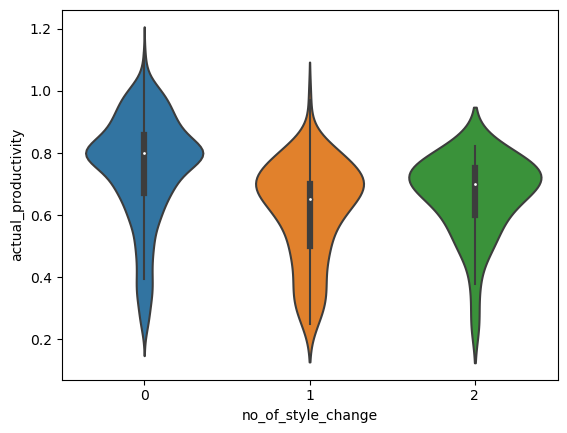

In [41]:
sns.violinplot(data=train, x='no_of_style_change', y='actual_productivity')

In [43]:
cat_list = ['quarter', 'department', 'day']
le = LabelEncoder()
for cat in cat_list:
    train[cat] = le.fit_transform(train[cat])
    test[cat] = le.transform(test[cat])

C:\Users\회의실\AppData\Local\Temp\ipykernel_6452\2612009022.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[cat] = le.fit_transform(train[cat])


In [44]:
drop_list = ['wip']
temp1 = train
temp2 = test
train = train.drop(drop_list, axis=1)
test = test.drop(drop_list, axis=1)

In [45]:
train.head()

,quarter,department,day,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,special_incentive
0,0,1,0,80.0,26.16,0.27315,98,0,0,0,59,0.94073,0
1,0,0,0,75.0,3.94,0.03704,0,0,0,0,8,0.88650,0
2,0,1,0,80.0,11.41,0.14120,50,0,0,0,30,0.80057,0
3,0,1,0,80.0,11.41,0.14120,50,0,0,0,30,0.80057,0
4,0,1,0,80.0,25.90,0.07407,50,0,0,0,56,0.80038,0


In [46]:
def NMAE(true, pred):
    score = np.mean(np.abs(true - pred) / true)
    return score

In [47]:
sampler = TPESampler()

In [48]:
X, y = train.drop(['actual_productivity'], axis=1), train['actual_productivity']
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [56]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
    param = {
        'lambda':trial.suggest_float('lambda', 1e-3, 0.1),
        'alpha':trial.suggest_float('alpha', 1e-3, 1.0),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0.4, 1),
        'subsample':trial.suggest_float('subsample', 0.4, 1),
        'learning_rate':trial.suggest_float('learning_rate', 0.0001, 0.1),
        'n_estimators':trial.suggest_int('n_estimators', 100, 1000),
        'max_depth':trial.suggest_int('max_depth', 4, 8),
        'min_child_weight':trial.suggest_int('min_child_weight', 2, 50),
    }
    model = XGBRegressor(**param)
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100)
    preds = model.predict(test_x)
    nmae = NMAE(test_y, preds)
    return nmae

In [57]:
study_xgb = optuna.create_study(
    direction='minimize',
    study_name = 'Xgboost Optuna',
    sampler=sampler)
study_xgb.optimize(objective, n_trials=50)

[I 2022-11-01 14:43:45,036] A new study created in memory with name: Xgboost Optuna


[0]	validation_0-rmse:0.28629
[1]	validation_0-rmse:0.27603
[2]	validation_0-rmse:0.26631
[3]	validation_0-rmse:0.25813
[4]	validation_0-rmse:0.24935
[5]	validation_0-rmse:0.24131
[6]	validation_0-rmse:0.23375
[7]	validation_0-rmse:0.22725
[8]	validation_0-rmse:0.22044
[9]	validation_0-rmse:0.21447
[10]	validation_0-rmse:0.20870
[11]	validation_0-rmse:0.20409
[12]	validation_0-rmse:0.19868
[13]	validation_0-rmse:0.19304
[14]	validation_0-rmse:0.18872
[15]	validation_0-rmse:0.18459
[16]	validation_0-rmse:0.18080
[17]	validation_0-rmse:0.17665
[18]	validation_0-rmse:0.17392
[19]	validation_0-rmse:0.17070
[20]	validation_0-rmse:0.16798
[21]	validation_0-rmse:0.16547
[22]	validation_0-rmse:0.16301
[23]	validation_0-rmse:0.16085
[24]	validation_0-rmse:0.15795
[25]	validation_0-rmse:0.15560
[26]	validation_0-rmse:0.15346
[27]	validation_0-rmse:0.15165
[28]	validation_0-rmse:0.15007
[29]	validation_0-rmse:0.14820
[30]	validation_0-rmse:0.14667
[31]	validation_0-rmse:0.14536
[32]	validation_0-

[I 2022-11-01 14:43:46,154] Trial 0 finished with value: 0.1485643790500571 and parameters: {'lambda': 0.03827353388068856, 'alpha': 0.7506574526608035, 'colsample_bytree': 0.5228479812184135, 'subsample': 0.6736484151539954, 'learning_rate': 0.050413414312504845, 'n_estimators': 309, 'max_depth': 7, 'min_child_weight': 40}. Best is trial 0 with value: 0.1485643790500571.


[0]	validation_0-rmse:0.28368
[1]	validation_0-rmse:0.27110
[2]	validation_0-rmse:0.25870
[3]	validation_0-rmse:0.24915
[4]	validation_0-rmse:0.23868
[5]	validation_0-rmse:0.22931
[6]	validation_0-rmse:0.22043
[7]	validation_0-rmse:0.21234
[8]	validation_0-rmse:0.20498
[9]	validation_0-rmse:0.19858
[10]	validation_0-rmse:0.19215
[11]	validation_0-rmse:0.18652
[12]	validation_0-rmse:0.18128
[13]	validation_0-rmse:0.17572
[14]	validation_0-rmse:0.17104
[15]	validation_0-rmse:0.16733
[16]	validation_0-rmse:0.16322
[17]	validation_0-rmse:0.15942
[18]	validation_0-rmse:0.15634
[19]	validation_0-rmse:0.15267
[20]	validation_0-rmse:0.15039
[21]	validation_0-rmse:0.14801
[22]	validation_0-rmse:0.14585
[23]	validation_0-rmse:0.14367
[24]	validation_0-rmse:0.14143
[25]	validation_0-rmse:0.13920
[26]	validation_0-rmse:0.13727
[27]	validation_0-rmse:0.13574
[28]	validation_0-rmse:0.13402
[29]	validation_0-rmse:0.13238
[30]	validation_0-rmse:0.13068
[31]	validation_0-rmse:0.12948
[32]	validation_0-

[I 2022-11-01 14:43:47,229] Trial 1 finished with value: 0.13155266144988487 and parameters: {'lambda': 0.08600720239763467, 'alpha': 0.18023402873313965, 'colsample_bytree': 0.4966662694776229, 'subsample': 0.9239154651586958, 'learning_rate': 0.05868589266624079, 'n_estimators': 477, 'max_depth': 6, 'min_child_weight': 7}. Best is trial 1 with value: 0.13155266144988487.


[0]	validation_0-rmse:0.28320
[1]	validation_0-rmse:0.26998
[2]	validation_0-rmse:0.25765
[3]	validation_0-rmse:0.24676
[4]	validation_0-rmse:0.23666
[5]	validation_0-rmse:0.22761
[6]	validation_0-rmse:0.21864
[7]	validation_0-rmse:0.21051
[8]	validation_0-rmse:0.20275
[9]	validation_0-rmse:0.19550
[10]	validation_0-rmse:0.18969
[11]	validation_0-rmse:0.18370
[12]	validation_0-rmse:0.17837
[13]	validation_0-rmse:0.17286
[14]	validation_0-rmse:0.16878
[15]	validation_0-rmse:0.16468
[16]	validation_0-rmse:0.16128
[17]	validation_0-rmse:0.15771
[18]	validation_0-rmse:0.15422
[19]	validation_0-rmse:0.15128
[20]	validation_0-rmse:0.14902
[21]	validation_0-rmse:0.14636
[22]	validation_0-rmse:0.14411
[23]	validation_0-rmse:0.14240
[24]	validation_0-rmse:0.14056
[25]	validation_0-rmse:0.13908
[26]	validation_0-rmse:0.13734
[27]	validation_0-rmse:0.13580
[28]	validation_0-rmse:0.13443
[29]	validation_0-rmse:0.13338
[30]	validation_0-rmse:0.13263
[31]	validation_0-rmse:0.13185
[32]	validation_0-

[I 2022-11-01 14:43:48,676] Trial 2 finished with value: 0.1425040151246657 and parameters: {'lambda': 0.06721718842642573, 'alpha': 0.7468321848218734, 'colsample_bytree': 0.9820037165754331, 'subsample': 0.5759585704008936, 'learning_rate': 0.06487379460842152, 'n_estimators': 282, 'max_depth': 6, 'min_child_weight': 12}. Best is trial 1 with value: 0.13155266144988487.


[0]	validation_0-rmse:0.28374
[1]	validation_0-rmse:0.27104
[2]	validation_0-rmse:0.25893
[3]	validation_0-rmse:0.24971
[4]	validation_0-rmse:0.23929
[5]	validation_0-rmse:0.23016
[6]	validation_0-rmse:0.22158
[7]	validation_0-rmse:0.21419
[8]	validation_0-rmse:0.20678
[9]	validation_0-rmse:0.20064
[10]	validation_0-rmse:0.19457
[11]	validation_0-rmse:0.18979
[12]	validation_0-rmse:0.18467
[13]	validation_0-rmse:0.17887
[14]	validation_0-rmse:0.17450
[15]	validation_0-rmse:0.17118
[16]	validation_0-rmse:0.16755
[17]	validation_0-rmse:0.16360
[18]	validation_0-rmse:0.16058
[19]	validation_0-rmse:0.15735
[20]	validation_0-rmse:0.15553
[21]	validation_0-rmse:0.15328
[22]	validation_0-rmse:0.15141
[23]	validation_0-rmse:0.14947
[24]	validation_0-rmse:0.14742
[25]	validation_0-rmse:0.14525
[26]	validation_0-rmse:0.14331
[27]	validation_0-rmse:0.14178
[28]	validation_0-rmse:0.14081
[29]	validation_0-rmse:0.13932
[30]	validation_0-rmse:0.13791
[31]	validation_0-rmse:0.13700
[32]	validation_0-

[I 2022-11-01 14:43:50,572] Trial 3 finished with value: 0.14890015489896508 and parameters: {'lambda': 0.08965111210218982, 'alpha': 0.30128459152975845, 'colsample_bytree': 0.4665528169863255, 'subsample': 0.6886998895955673, 'learning_rate': 0.0605270735888399, 'n_estimators': 532, 'max_depth': 8, 'min_child_weight': 38}. Best is trial 1 with value: 0.13155266144988487.


[0]	validation_0-rmse:0.29084
[1]	validation_0-rmse:0.28456
[2]	validation_0-rmse:0.27851
[3]	validation_0-rmse:0.27261
[4]	validation_0-rmse:0.26688
[5]	validation_0-rmse:0.26152
[6]	validation_0-rmse:0.25585
[7]	validation_0-rmse:0.25048
[8]	validation_0-rmse:0.24550
[9]	validation_0-rmse:0.24081
[10]	validation_0-rmse:0.23639
[11]	validation_0-rmse:0.23211
[12]	validation_0-rmse:0.22788
[13]	validation_0-rmse:0.22358
[14]	validation_0-rmse:0.21953
[15]	validation_0-rmse:0.21570
[16]	validation_0-rmse:0.21216
[17]	validation_0-rmse:0.20857
[18]	validation_0-rmse:0.20547
[19]	validation_0-rmse:0.20218
[20]	validation_0-rmse:0.19910
[21]	validation_0-rmse:0.19604
[22]	validation_0-rmse:0.19303
[23]	validation_0-rmse:0.19034
[24]	validation_0-rmse:0.18745
[25]	validation_0-rmse:0.18486
[26]	validation_0-rmse:0.18221
[27]	validation_0-rmse:0.17981
[28]	validation_0-rmse:0.17764
[29]	validation_0-rmse:0.17550
[30]	validation_0-rmse:0.17332
[31]	validation_0-rmse:0.17155
[32]	validation_0-

[I 2022-11-01 14:43:52,532] Trial 4 finished with value: 0.1425722222152266 and parameters: {'lambda': 0.0924686236074612, 'alpha': 0.5981912002104578, 'colsample_bytree': 0.8299393008770901, 'subsample': 0.6879428613409878, 'learning_rate': 0.02918877277669139, 'n_estimators': 928, 'max_depth': 8, 'min_child_weight': 20}. Best is trial 1 with value: 0.13155266144988487.


[0]	validation_0-rmse:0.29128
[1]	validation_0-rmse:0.28555
[2]	validation_0-rmse:0.27977
[3]	validation_0-rmse:0.27497
[4]	validation_0-rmse:0.26954
[5]	validation_0-rmse:0.26447
[6]	validation_0-rmse:0.25943
[7]	validation_0-rmse:0.25505
[8]	validation_0-rmse:0.25036
[9]	validation_0-rmse:0.24643
[10]	validation_0-rmse:0.24232
[11]	validation_0-rmse:0.23863
[12]	validation_0-rmse:0.23481
[13]	validation_0-rmse:0.23043
[14]	validation_0-rmse:0.22677
[15]	validation_0-rmse:0.22362
[16]	validation_0-rmse:0.22016
[17]	validation_0-rmse:0.21653
[18]	validation_0-rmse:0.21353
[19]	validation_0-rmse:0.20989
[20]	validation_0-rmse:0.20735
[21]	validation_0-rmse:0.20447
[22]	validation_0-rmse:0.20201
[23]	validation_0-rmse:0.19948
[24]	validation_0-rmse:0.19678
[25]	validation_0-rmse:0.19415
[26]	validation_0-rmse:0.19158
[27]	validation_0-rmse:0.18914
[28]	validation_0-rmse:0.18721
[29]	validation_0-rmse:0.18480
[30]	validation_0-rmse:0.18247
[31]	validation_0-rmse:0.18070
[32]	validation_0-

[I 2022-11-01 14:43:56,277] Trial 5 finished with value: 0.1377962565969148 and parameters: {'lambda': 0.023211361760366925, 'alpha': 0.9565499442154655, 'colsample_bytree': 0.4453078091271463, 'subsample': 0.6641737691902976, 'learning_rate': 0.02768992984702451, 'n_estimators': 575, 'max_depth': 5, 'min_child_weight': 7}. Best is trial 1 with value: 0.13155266144988487.


[0]	validation_0-rmse:0.28727
[1]	validation_0-rmse:0.27772
[2]	validation_0-rmse:0.26860
[3]	validation_0-rmse:0.26130
[4]	validation_0-rmse:0.25349
[5]	validation_0-rmse:0.24630
[6]	validation_0-rmse:0.23913
[7]	validation_0-rmse:0.23265
[8]	validation_0-rmse:0.22627
[9]	validation_0-rmse:0.22120
[10]	validation_0-rmse:0.21553
[11]	validation_0-rmse:0.21095
[12]	validation_0-rmse:0.20626
[13]	validation_0-rmse:0.20112
[14]	validation_0-rmse:0.19683
[15]	validation_0-rmse:0.19350
[16]	validation_0-rmse:0.18976
[17]	validation_0-rmse:0.18555
[18]	validation_0-rmse:0.18233
[19]	validation_0-rmse:0.17858
[20]	validation_0-rmse:0.17626
[21]	validation_0-rmse:0.17355
[22]	validation_0-rmse:0.17123
[23]	validation_0-rmse:0.16873
[24]	validation_0-rmse:0.16623
[25]	validation_0-rmse:0.16375
[26]	validation_0-rmse:0.16141
[27]	validation_0-rmse:0.15949
[28]	validation_0-rmse:0.15772
[29]	validation_0-rmse:0.15576
[30]	validation_0-rmse:0.15387
[31]	validation_0-rmse:0.15239
[32]	validation_0-

[I 2022-11-01 14:43:58,184] Trial 6 finished with value: 0.14986516296201594 and parameters: {'lambda': 0.08465736928249416, 'alpha': 0.5336372648351058, 'colsample_bytree': 0.4258389785749538, 'subsample': 0.5608344904818934, 'learning_rate': 0.04573739576849877, 'n_estimators': 438, 'max_depth': 4, 'min_child_weight': 48}. Best is trial 1 with value: 0.13155266144988487.


[0]	validation_0-rmse:0.28364
[1]	validation_0-rmse:0.27126
[2]	validation_0-rmse:0.25941
[3]	validation_0-rmse:0.24981
[4]	validation_0-rmse:0.23926
[5]	validation_0-rmse:0.23010
[6]	validation_0-rmse:0.22177
[7]	validation_0-rmse:0.21445
[8]	validation_0-rmse:0.20698
[9]	validation_0-rmse:0.20049
[10]	validation_0-rmse:0.19469
[11]	validation_0-rmse:0.18946
[12]	validation_0-rmse:0.18382
[13]	validation_0-rmse:0.17798
[14]	validation_0-rmse:0.17343
[15]	validation_0-rmse:0.16940
[16]	validation_0-rmse:0.16587
[17]	validation_0-rmse:0.16198
[18]	validation_0-rmse:0.15903
[19]	validation_0-rmse:0.15585
[20]	validation_0-rmse:0.15343
[21]	validation_0-rmse:0.15138
[22]	validation_0-rmse:0.14940
[23]	validation_0-rmse:0.14760
[24]	validation_0-rmse:0.14513
[25]	validation_0-rmse:0.14330
[26]	validation_0-rmse:0.14164
[27]	validation_0-rmse:0.14044
[28]	validation_0-rmse:0.13924
[29]	validation_0-rmse:0.13783
[30]	validation_0-rmse:0.13670
[31]	validation_0-rmse:0.13589
[32]	validation_0-

[I 2022-11-01 14:43:59,515] Trial 7 finished with value: 0.1467966809392571 and parameters: {'lambda': 0.03564090822896702, 'alpha': 0.42927638379713007, 'colsample_bytree': 0.503418577419232, 'subsample': 0.6347233495091326, 'learning_rate': 0.06145162280268446, 'n_estimators': 947, 'max_depth': 5, 'min_child_weight': 32}. Best is trial 1 with value: 0.13155266144988487.


[0]	validation_0-rmse:0.29484
[1]	validation_0-rmse:0.29237
[2]	validation_0-rmse:0.29004
[3]	validation_0-rmse:0.28770
[4]	validation_0-rmse:0.28537
[5]	validation_0-rmse:0.28318
[6]	validation_0-rmse:0.28101
[7]	validation_0-rmse:0.27875
[8]	validation_0-rmse:0.27659
[9]	validation_0-rmse:0.27449
[10]	validation_0-rmse:0.27243
[11]	validation_0-rmse:0.27038
[12]	validation_0-rmse:0.26820
[13]	validation_0-rmse:0.26610
[14]	validation_0-rmse:0.26411
[15]	validation_0-rmse:0.26216
[16]	validation_0-rmse:0.26021
[17]	validation_0-rmse:0.25815
[18]	validation_0-rmse:0.25634
[19]	validation_0-rmse:0.25446
[20]	validation_0-rmse:0.25269
[21]	validation_0-rmse:0.25093
[22]	validation_0-rmse:0.24923
[23]	validation_0-rmse:0.24749
[24]	validation_0-rmse:0.24569
[25]	validation_0-rmse:0.24392
[26]	validation_0-rmse:0.24224
[27]	validation_0-rmse:0.24061
[28]	validation_0-rmse:0.23898
[29]	validation_0-rmse:0.23724
[30]	validation_0-rmse:0.23560
[31]	validation_0-rmse:0.23400
[32]	validation_0-

[I 2022-11-01 14:44:01,829] Trial 8 finished with value: 0.1493988775462478 and parameters: {'lambda': 0.09703481243520598, 'alpha': 0.8224896236335366, 'colsample_bytree': 0.8765195226994231, 'subsample': 0.4245117309150006, 'learning_rate': 0.011381304458357876, 'n_estimators': 322, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 1 with value: 0.13155266144988487.


[0]	validation_0-rmse:0.29007
[1]	validation_0-rmse:0.28315
[2]	validation_0-rmse:0.27640
[3]	validation_0-rmse:0.26991
[4]	validation_0-rmse:0.26366
[5]	validation_0-rmse:0.25775
[6]	validation_0-rmse:0.25227
[7]	validation_0-rmse:0.24673
[8]	validation_0-rmse:0.24146
[9]	validation_0-rmse:0.23629
[10]	validation_0-rmse:0.23167
[11]	validation_0-rmse:0.22715
[12]	validation_0-rmse:0.22266
[13]	validation_0-rmse:0.21818
[14]	validation_0-rmse:0.21405
[15]	validation_0-rmse:0.21006
[16]	validation_0-rmse:0.20634
[17]	validation_0-rmse:0.20263
[18]	validation_0-rmse:0.19945
[19]	validation_0-rmse:0.19596
[20]	validation_0-rmse:0.19290
[21]	validation_0-rmse:0.19007
[22]	validation_0-rmse:0.18709
[23]	validation_0-rmse:0.18428
[24]	validation_0-rmse:0.18131
[25]	validation_0-rmse:0.17875
[26]	validation_0-rmse:0.17611
[27]	validation_0-rmse:0.17378
[28]	validation_0-rmse:0.17155
[29]	validation_0-rmse:0.16921
[30]	validation_0-rmse:0.16688
[31]	validation_0-rmse:0.16507
[32]	validation_0-

[I 2022-11-01 14:44:03,527] Trial 9 finished with value: 0.14247723156112826 and parameters: {'lambda': 0.07272491785122104, 'alpha': 0.054922962508324936, 'colsample_bytree': 0.7143958234404773, 'subsample': 0.9264501904718229, 'learning_rate': 0.030617876848356967, 'n_estimators': 923, 'max_depth': 5, 'min_child_weight': 38}. Best is trial 1 with value: 0.13155266144988487.


[0]	validation_0-rmse:0.27487
[1]	validation_0-rmse:0.25603
[2]	validation_0-rmse:0.23850
[3]	validation_0-rmse:0.22448
[4]	validation_0-rmse:0.21046
[5]	validation_0-rmse:0.19812
[6]	validation_0-rmse:0.18765
[7]	validation_0-rmse:0.17767
[8]	validation_0-rmse:0.16996
[9]	validation_0-rmse:0.16304
[10]	validation_0-rmse:0.15705
[11]	validation_0-rmse:0.15163
[12]	validation_0-rmse:0.14705
[13]	validation_0-rmse:0.14250
[14]	validation_0-rmse:0.13860
[15]	validation_0-rmse:0.13603
[16]	validation_0-rmse:0.13313
[17]	validation_0-rmse:0.13077
[18]	validation_0-rmse:0.12900
[19]	validation_0-rmse:0.12709
[20]	validation_0-rmse:0.12569
[21]	validation_0-rmse:0.12481
[22]	validation_0-rmse:0.12383
[23]	validation_0-rmse:0.12303
[24]	validation_0-rmse:0.12198
[25]	validation_0-rmse:0.12127
[26]	validation_0-rmse:0.12072
[27]	validation_0-rmse:0.12042
[28]	validation_0-rmse:0.11987
[29]	validation_0-rmse:0.11936
[30]	validation_0-rmse:0.11888
[31]	validation_0-rmse:0.11839
[32]	validation_0-

[I 2022-11-01 14:44:04,216] Trial 10 finished with value: 0.1337077764626157 and parameters: {'lambda': 0.002472169199453582, 'alpha': 0.05911360042588898, 'colsample_bytree': 0.6198473580827482, 'subsample': 0.9955134872337869, 'learning_rate': 0.09321142905523447, 'n_estimators': 121, 'max_depth': 7, 'min_child_weight': 22}. Best is trial 1 with value: 0.13155266144988487.


[0]	validation_0-rmse:0.27398
[1]	validation_0-rmse:0.25375
[2]	validation_0-rmse:0.23530
[3]	validation_0-rmse:0.22089
[4]	validation_0-rmse:0.20675
[5]	validation_0-rmse:0.19434
[6]	validation_0-rmse:0.18388
[7]	validation_0-rmse:0.17427
[8]	validation_0-rmse:0.16663
[9]	validation_0-rmse:0.15972
[10]	validation_0-rmse:0.15375
[11]	validation_0-rmse:0.14843
[12]	validation_0-rmse:0.14398
[13]	validation_0-rmse:0.13976
[14]	validation_0-rmse:0.13612
[15]	validation_0-rmse:0.13381
[16]	validation_0-rmse:0.13106
[17]	validation_0-rmse:0.12922
[18]	validation_0-rmse:0.12770
[19]	validation_0-rmse:0.12600
[20]	validation_0-rmse:0.12499
[21]	validation_0-rmse:0.12432
[22]	validation_0-rmse:0.12342
[23]	validation_0-rmse:0.12278
[24]	validation_0-rmse:0.12177
[25]	validation_0-rmse:0.12116
[26]	validation_0-rmse:0.12084
[27]	validation_0-rmse:0.12061
[28]	validation_0-rmse:0.12000
[29]	validation_0-rmse:0.11964
[30]	validation_0-rmse:0.11902
[31]	validation_0-rmse:0.11865
[32]	validation_0-

[I 2022-11-01 14:44:05,007] Trial 11 finished with value: 0.13360132878906977 and parameters: {'lambda': 0.004999615033491023, 'alpha': 0.039370223518533316, 'colsample_bytree': 0.6290246621173958, 'subsample': 0.988862735753048, 'learning_rate': 0.09753090426605313, 'n_estimators': 139, 'max_depth': 7, 'min_child_weight': 23}. Best is trial 1 with value: 0.13155266144988487.


[0]	validation_0-rmse:0.27456
[1]	validation_0-rmse:0.25453
[2]	validation_0-rmse:0.23668
[3]	validation_0-rmse:0.22217
[4]	validation_0-rmse:0.20766
[5]	validation_0-rmse:0.19565
[6]	validation_0-rmse:0.18515
[7]	validation_0-rmse:0.17528
[8]	validation_0-rmse:0.16723
[9]	validation_0-rmse:0.16074
[10]	validation_0-rmse:0.15484
[11]	validation_0-rmse:0.14964
[12]	validation_0-rmse:0.14537
[13]	validation_0-rmse:0.14072
[14]	validation_0-rmse:0.13698
[15]	validation_0-rmse:0.13425
[16]	validation_0-rmse:0.13151
[17]	validation_0-rmse:0.12914
[18]	validation_0-rmse:0.12689
[19]	validation_0-rmse:0.12474
[20]	validation_0-rmse:0.12325
[21]	validation_0-rmse:0.12224
[22]	validation_0-rmse:0.12123
[23]	validation_0-rmse:0.12047
[24]	validation_0-rmse:0.11939
[25]	validation_0-rmse:0.11876
[26]	validation_0-rmse:0.11832
[27]	validation_0-rmse:0.11792
[28]	validation_0-rmse:0.11753
[29]	validation_0-rmse:0.11710
[30]	validation_0-rmse:0.11654
[31]	validation_0-rmse:0.11623
[32]	validation_0-

[I 2022-11-01 14:44:05,898] Trial 12 finished with value: 0.13110684291121807 and parameters: {'lambda': 0.059047157741617506, 'alpha': 0.24459547608204216, 'colsample_bytree': 0.6180237373473927, 'subsample': 0.8514549414140635, 'learning_rate': 0.09748872105585883, 'n_estimators': 705, 'max_depth': 7, 'min_child_weight': 3}. Best is trial 12 with value: 0.13110684291121807.


[0]	validation_0-rmse:0.27867
[1]	validation_0-rmse:0.26184
[2]	validation_0-rmse:0.24649
[3]	validation_0-rmse:0.23384
[4]	validation_0-rmse:0.22080
[5]	validation_0-rmse:0.20980
[6]	validation_0-rmse:0.19948
[7]	validation_0-rmse:0.19001
[8]	validation_0-rmse:0.18207
[9]	validation_0-rmse:0.17534
[10]	validation_0-rmse:0.16933
[11]	validation_0-rmse:0.16346
[12]	validation_0-rmse:0.15812
[13]	validation_0-rmse:0.15292
[14]	validation_0-rmse:0.14827
[15]	validation_0-rmse:0.14459
[16]	validation_0-rmse:0.14124
[17]	validation_0-rmse:0.13820
[18]	validation_0-rmse:0.13577
[19]	validation_0-rmse:0.13297
[20]	validation_0-rmse:0.13105
[21]	validation_0-rmse:0.12957
[22]	validation_0-rmse:0.12812
[23]	validation_0-rmse:0.12683
[24]	validation_0-rmse:0.12514
[25]	validation_0-rmse:0.12406
[26]	validation_0-rmse:0.12294
[27]	validation_0-rmse:0.12208
[28]	validation_0-rmse:0.12137
[29]	validation_0-rmse:0.12053
[30]	validation_0-rmse:0.11979
[31]	validation_0-rmse:0.11910
[32]	validation_0-

[I 2022-11-01 14:44:06,874] Trial 13 finished with value: 0.12797514216693112 and parameters: {'lambda': 0.060910331379404783, 'alpha': 0.25157004232441027, 'colsample_bytree': 0.5981835348801323, 'subsample': 0.8248881000959826, 'learning_rate': 0.07995066323588154, 'n_estimators': 744, 'max_depth': 6, 'min_child_weight': 2}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.27852
[1]	validation_0-rmse:0.26127
[2]	validation_0-rmse:0.24606
[3]	validation_0-rmse:0.23193
[4]	validation_0-rmse:0.21908
[5]	validation_0-rmse:0.20803
[6]	validation_0-rmse:0.19780
[7]	validation_0-rmse:0.18815
[8]	validation_0-rmse:0.17998
[9]	validation_0-rmse:0.17277
[10]	validation_0-rmse:0.16660
[11]	validation_0-rmse:0.16071
[12]	validation_0-rmse:0.15565
[13]	validation_0-rmse:0.15064
[14]	validation_0-rmse:0.14587
[15]	validation_0-rmse:0.14233
[16]	validation_0-rmse:0.13924
[17]	validation_0-rmse:0.13645
[18]	validation_0-rmse:0.13399
[19]	validation_0-rmse:0.13185
[20]	validation_0-rmse:0.12984
[21]	validation_0-rmse:0.12839
[22]	validation_0-rmse:0.12705
[23]	validation_0-rmse:0.12553
[24]	validation_0-rmse:0.12416
[25]	validation_0-rmse:0.12320
[26]	validation_0-rmse:0.12212
[27]	validation_0-rmse:0.12123
[28]	validation_0-rmse:0.12059
[29]	validation_0-rmse:0.12009
[30]	validation_0-rmse:0.11929
[31]	validation_0-rmse:0.11860
[32]	validation_0-

[I 2022-11-01 14:44:07,700] Trial 14 finished with value: 0.12897183176894308 and parameters: {'lambda': 0.05827827341624712, 'alpha': 0.309590109307554, 'colsample_bytree': 0.6965402631476953, 'subsample': 0.8035514456988723, 'learning_rate': 0.08070392942309101, 'n_estimators': 714, 'max_depth': 7, 'min_child_weight': 2}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.27889
[1]	validation_0-rmse:0.26217
[2]	validation_0-rmse:0.24709
[3]	validation_0-rmse:0.23334
[4]	validation_0-rmse:0.22067
[5]	validation_0-rmse:0.20982
[6]	validation_0-rmse:0.20033
[7]	validation_0-rmse:0.19089
[8]	validation_0-rmse:0.18302
[9]	validation_0-rmse:0.17592
[10]	validation_0-rmse:0.17005
[11]	validation_0-rmse:0.16423
[12]	validation_0-rmse:0.15920
[13]	validation_0-rmse:0.15401
[14]	validation_0-rmse:0.14948
[15]	validation_0-rmse:0.14595
[16]	validation_0-rmse:0.14280
[17]	validation_0-rmse:0.14018
[18]	validation_0-rmse:0.13792
[19]	validation_0-rmse:0.13585
[20]	validation_0-rmse:0.13411
[21]	validation_0-rmse:0.13280
[22]	validation_0-rmse:0.13133
[23]	validation_0-rmse:0.12983
[24]	validation_0-rmse:0.12840
[25]	validation_0-rmse:0.12735
[26]	validation_0-rmse:0.12628
[27]	validation_0-rmse:0.12585
[28]	validation_0-rmse:0.12501
[29]	validation_0-rmse:0.12417
[30]	validation_0-rmse:0.12357
[31]	validation_0-rmse:0.12299
[32]	validation_0-

[I 2022-11-01 14:44:08,898] Trial 15 finished with value: 0.1343417591052424 and parameters: {'lambda': 0.048352891409049956, 'alpha': 0.38794413722853044, 'colsample_bytree': 0.7341280221143625, 'subsample': 0.7872080248139368, 'learning_rate': 0.07968641795596731, 'n_estimators': 759, 'max_depth': 6, 'min_child_weight': 17}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.27822
[1]	validation_0-rmse:0.26125
[2]	validation_0-rmse:0.24551
[3]	validation_0-rmse:0.23185
[4]	validation_0-rmse:0.21933
[5]	validation_0-rmse:0.20786
[6]	validation_0-rmse:0.19755
[7]	validation_0-rmse:0.18841
[8]	validation_0-rmse:0.18039
[9]	validation_0-rmse:0.17341
[10]	validation_0-rmse:0.16706
[11]	validation_0-rmse:0.16078
[12]	validation_0-rmse:0.15582
[13]	validation_0-rmse:0.15097
[14]	validation_0-rmse:0.14709
[15]	validation_0-rmse:0.14346
[16]	validation_0-rmse:0.14042
[17]	validation_0-rmse:0.13735
[18]	validation_0-rmse:0.13497
[19]	validation_0-rmse:0.13316
[20]	validation_0-rmse:0.13159
[21]	validation_0-rmse:0.12994
[22]	validation_0-rmse:0.12852
[23]	validation_0-rmse:0.12721
[24]	validation_0-rmse:0.12581
[25]	validation_0-rmse:0.12492
[26]	validation_0-rmse:0.12408
[27]	validation_0-rmse:0.12316
[28]	validation_0-rmse:0.12268
[29]	validation_0-rmse:0.12212
[30]	validation_0-rmse:0.12151
[31]	validation_0-rmse:0.12089
[32]	validation_0-

[I 2022-11-01 14:44:09,713] Trial 16 finished with value: 0.13217287037588174 and parameters: {'lambda': 0.05373215382786667, 'alpha': 0.1616578094931519, 'colsample_bytree': 0.7883064076801696, 'subsample': 0.7988797947575221, 'learning_rate': 0.07907279704345005, 'n_estimators': 754, 'max_depth': 8, 'min_child_weight': 4}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.27860
[1]	validation_0-rmse:0.26195
[2]	validation_0-rmse:0.24620
[3]	validation_0-rmse:0.23385
[4]	validation_0-rmse:0.22097
[5]	validation_0-rmse:0.20999
[6]	validation_0-rmse:0.20035
[7]	validation_0-rmse:0.19230
[8]	validation_0-rmse:0.18453
[9]	validation_0-rmse:0.17763
[10]	validation_0-rmse:0.17136
[11]	validation_0-rmse:0.16593
[12]	validation_0-rmse:0.16051
[13]	validation_0-rmse:0.15518
[14]	validation_0-rmse:0.15142
[15]	validation_0-rmse:0.14814
[16]	validation_0-rmse:0.14491
[17]	validation_0-rmse:0.14224
[18]	validation_0-rmse:0.14003
[19]	validation_0-rmse:0.13725
[20]	validation_0-rmse:0.13539
[21]	validation_0-rmse:0.13408
[22]	validation_0-rmse:0.13260
[23]	validation_0-rmse:0.13122
[24]	validation_0-rmse:0.12944
[25]	validation_0-rmse:0.12819
[26]	validation_0-rmse:0.12722
[27]	validation_0-rmse:0.12644
[28]	validation_0-rmse:0.12572
[29]	validation_0-rmse:0.12475
[30]	validation_0-rmse:0.12389
[31]	validation_0-rmse:0.12317
[32]	validation_0-

[I 2022-11-01 14:44:11,826] Trial 17 finished with value: 0.1330607674700902 and parameters: {'lambda': 0.07089702182208996, 'alpha': 0.34201105380496377, 'colsample_bytree': 0.5780004841952726, 'subsample': 0.7780442642946229, 'learning_rate': 0.0809991420499471, 'n_estimators': 628, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.28048
[1]	validation_0-rmse:0.26520
[2]	validation_0-rmse:0.25133
[3]	validation_0-rmse:0.23855
[4]	validation_0-rmse:0.22761
[5]	validation_0-rmse:0.21734
[6]	validation_0-rmse:0.20810
[7]	validation_0-rmse:0.19952
[8]	validation_0-rmse:0.19172
[9]	validation_0-rmse:0.18481
[10]	validation_0-rmse:0.17905
[11]	validation_0-rmse:0.17346
[12]	validation_0-rmse:0.16842
[13]	validation_0-rmse:0.16324
[14]	validation_0-rmse:0.15927
[15]	validation_0-rmse:0.15559
[16]	validation_0-rmse:0.15215
[17]	validation_0-rmse:0.14915
[18]	validation_0-rmse:0.14665
[19]	validation_0-rmse:0.14426
[20]	validation_0-rmse:0.14231
[21]	validation_0-rmse:0.14076
[22]	validation_0-rmse:0.13897
[23]	validation_0-rmse:0.13753
[24]	validation_0-rmse:0.13568
[25]	validation_0-rmse:0.13451
[26]	validation_0-rmse:0.13314
[27]	validation_0-rmse:0.13229
[28]	validation_0-rmse:0.13142
[29]	validation_0-rmse:0.13036
[30]	validation_0-rmse:0.12939
[31]	validation_0-rmse:0.12854
[32]	validation_0-

[I 2022-11-01 14:44:13,221] Trial 18 finished with value: 0.14116739356050992 and parameters: {'lambda': 0.04401169189352215, 'alpha': 0.5539670457254816, 'colsample_bytree': 0.6902903097717958, 'subsample': 0.8546793146954723, 'learning_rate': 0.07362188939231595, 'n_estimators': 844, 'max_depth': 6, 'min_child_weight': 30}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.27661
[1]	validation_0-rmse:0.25864
[2]	validation_0-rmse:0.24132
[3]	validation_0-rmse:0.22812
[4]	validation_0-rmse:0.21472
[5]	validation_0-rmse:0.20294
[6]	validation_0-rmse:0.19194
[7]	validation_0-rmse:0.18326
[8]	validation_0-rmse:0.17523
[9]	validation_0-rmse:0.16818
[10]	validation_0-rmse:0.16223
[11]	validation_0-rmse:0.15675
[12]	validation_0-rmse:0.15150
[13]	validation_0-rmse:0.14608
[14]	validation_0-rmse:0.14205
[15]	validation_0-rmse:0.13903
[16]	validation_0-rmse:0.13628
[17]	validation_0-rmse:0.13365
[18]	validation_0-rmse:0.13137
[19]	validation_0-rmse:0.12912
[20]	validation_0-rmse:0.12729
[21]	validation_0-rmse:0.12592
[22]	validation_0-rmse:0.12492
[23]	validation_0-rmse:0.12367
[24]	validation_0-rmse:0.12212
[25]	validation_0-rmse:0.12105
[26]	validation_0-rmse:0.12044
[27]	validation_0-rmse:0.11943
[28]	validation_0-rmse:0.11897
[29]	validation_0-rmse:0.11831
[30]	validation_0-rmse:0.11752
[31]	validation_0-rmse:0.11690
[32]	validation_0-

[I 2022-11-01 14:44:14,389] Trial 19 finished with value: 0.13134700061056356 and parameters: {'lambda': 0.02488236119539798, 'alpha': 0.18596791312192765, 'colsample_bytree': 0.5513134447127429, 'subsample': 0.7373467923761171, 'learning_rate': 0.08799854255459169, 'n_estimators': 676, 'max_depth': 6, 'min_child_weight': 2}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.28094
[1]	validation_0-rmse:0.26597
[2]	validation_0-rmse:0.25240
[3]	validation_0-rmse:0.23969
[4]	validation_0-rmse:0.22829
[5]	validation_0-rmse:0.21792
[6]	validation_0-rmse:0.20857
[7]	validation_0-rmse:0.19945
[8]	validation_0-rmse:0.19162
[9]	validation_0-rmse:0.18443
[10]	validation_0-rmse:0.17831
[11]	validation_0-rmse:0.17253
[12]	validation_0-rmse:0.16718
[13]	validation_0-rmse:0.16181
[14]	validation_0-rmse:0.15705
[15]	validation_0-rmse:0.15305
[16]	validation_0-rmse:0.14972
[17]	validation_0-rmse:0.14637
[18]	validation_0-rmse:0.14361
[19]	validation_0-rmse:0.14075
[20]	validation_0-rmse:0.13863
[21]	validation_0-rmse:0.13682
[22]	validation_0-rmse:0.13476
[23]	validation_0-rmse:0.13307
[24]	validation_0-rmse:0.13118
[25]	validation_0-rmse:0.12981
[26]	validation_0-rmse:0.12849
[27]	validation_0-rmse:0.12758
[28]	validation_0-rmse:0.12664
[29]	validation_0-rmse:0.12547
[30]	validation_0-rmse:0.12452
[31]	validation_0-rmse:0.12363
[32]	validation_0-

[I 2022-11-01 14:44:16,104] Trial 20 finished with value: 0.1296118702881448 and parameters: {'lambda': 0.06028955659926243, 'alpha': 0.4602558393700945, 'colsample_bytree': 0.6820313494938613, 'subsample': 0.8643006658907517, 'learning_rate': 0.07083249586091016, 'n_estimators': 852, 'max_depth': 5, 'min_child_weight': 8}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.28108
[1]	validation_0-rmse:0.26619
[2]	validation_0-rmse:0.25256
[3]	validation_0-rmse:0.23988
[4]	validation_0-rmse:0.22856
[5]	validation_0-rmse:0.21820
[6]	validation_0-rmse:0.20887
[7]	validation_0-rmse:0.19978
[8]	validation_0-rmse:0.19190
[9]	validation_0-rmse:0.18472
[10]	validation_0-rmse:0.17877
[11]	validation_0-rmse:0.17297
[12]	validation_0-rmse:0.16765
[13]	validation_0-rmse:0.16238
[14]	validation_0-rmse:0.15768
[15]	validation_0-rmse:0.15372
[16]	validation_0-rmse:0.15028
[17]	validation_0-rmse:0.14694
[18]	validation_0-rmse:0.14422
[19]	validation_0-rmse:0.14174
[20]	validation_0-rmse:0.13957
[21]	validation_0-rmse:0.13773
[22]	validation_0-rmse:0.13567
[23]	validation_0-rmse:0.13408
[24]	validation_0-rmse:0.13229
[25]	validation_0-rmse:0.13093
[26]	validation_0-rmse:0.12954
[27]	validation_0-rmse:0.12847
[28]	validation_0-rmse:0.12765
[29]	validation_0-rmse:0.12653
[30]	validation_0-rmse:0.12559
[31]	validation_0-rmse:0.12470
[32]	validation_0-

[I 2022-11-01 14:44:17,729] Trial 21 finished with value: 0.13193874427854524 and parameters: {'lambda': 0.06202978116390881, 'alpha': 0.4720004350755718, 'colsample_bytree': 0.6723567118830713, 'subsample': 0.8581430204563021, 'learning_rate': 0.07068363749466386, 'n_estimators': 825, 'max_depth': 5, 'min_child_weight': 9}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.27739
[1]	validation_0-rmse:0.25915
[2]	validation_0-rmse:0.24326
[3]	validation_0-rmse:0.22831
[4]	validation_0-rmse:0.21568
[5]	validation_0-rmse:0.20445
[6]	validation_0-rmse:0.19328
[7]	validation_0-rmse:0.18359
[8]	validation_0-rmse:0.17556
[9]	validation_0-rmse:0.16873
[10]	validation_0-rmse:0.16261
[11]	validation_0-rmse:0.15692
[12]	validation_0-rmse:0.15258
[13]	validation_0-rmse:0.14787
[14]	validation_0-rmse:0.14361
[15]	validation_0-rmse:0.14021
[16]	validation_0-rmse:0.13728
[17]	validation_0-rmse:0.13501
[18]	validation_0-rmse:0.13299
[19]	validation_0-rmse:0.13104
[20]	validation_0-rmse:0.12956
[21]	validation_0-rmse:0.12820
[22]	validation_0-rmse:0.12695
[23]	validation_0-rmse:0.12565
[24]	validation_0-rmse:0.12440
[25]	validation_0-rmse:0.12362
[26]	validation_0-rmse:0.12263
[27]	validation_0-rmse:0.12196
[28]	validation_0-rmse:0.12134
[29]	validation_0-rmse:0.12030
[30]	validation_0-rmse:0.11946
[31]	validation_0-rmse:0.11861
[32]	validation_0-

[I 2022-11-01 14:44:18,979] Trial 22 finished with value: 0.12906553236890111 and parameters: {'lambda': 0.0797487966320925, 'alpha': 0.2959908269263458, 'colsample_bytree': 0.7631130934763155, 'subsample': 0.9103898453393762, 'learning_rate': 0.08662200010979183, 'n_estimators': 835, 'max_depth': 5, 'min_child_weight': 2}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.27693
[1]	validation_0-rmse:0.25837
[2]	validation_0-rmse:0.24223
[3]	validation_0-rmse:0.22706
[4]	validation_0-rmse:0.21388
[5]	validation_0-rmse:0.20257
[6]	validation_0-rmse:0.19219
[7]	validation_0-rmse:0.18301
[8]	validation_0-rmse:0.17507
[9]	validation_0-rmse:0.16814
[10]	validation_0-rmse:0.16224
[11]	validation_0-rmse:0.15704
[12]	validation_0-rmse:0.15272
[13]	validation_0-rmse:0.14828
[14]	validation_0-rmse:0.14425
[15]	validation_0-rmse:0.14102
[16]	validation_0-rmse:0.13846
[17]	validation_0-rmse:0.13585
[18]	validation_0-rmse:0.13392
[19]	validation_0-rmse:0.13217
[20]	validation_0-rmse:0.13072
[21]	validation_0-rmse:0.12911
[22]	validation_0-rmse:0.12754
[23]	validation_0-rmse:0.12636
[24]	validation_0-rmse:0.12513
[25]	validation_0-rmse:0.12438
[26]	validation_0-rmse:0.12341
[27]	validation_0-rmse:0.12271
[28]	validation_0-rmse:0.12219
[29]	validation_0-rmse:0.12184
[30]	validation_0-rmse:0.12140
[31]	validation_0-rmse:0.12056
[32]	validation_0-

[I 2022-11-01 14:44:20,276] Trial 23 finished with value: 0.1280973787698576 and parameters: {'lambda': 0.07693617090422405, 'alpha': 0.27786433676705224, 'colsample_bytree': 0.7827088709834038, 'subsample': 0.9233064122160375, 'learning_rate': 0.08990918665812497, 'n_estimators': 752, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.27726
[1]	validation_0-rmse:0.25967
[2]	validation_0-rmse:0.24370
[3]	validation_0-rmse:0.22900
[4]	validation_0-rmse:0.21591
[5]	validation_0-rmse:0.20464
[6]	validation_0-rmse:0.19384
[7]	validation_0-rmse:0.18433
[8]	validation_0-rmse:0.17660
[9]	validation_0-rmse:0.16980
[10]	validation_0-rmse:0.16350
[11]	validation_0-rmse:0.15736
[12]	validation_0-rmse:0.15313
[13]	validation_0-rmse:0.14813
[14]	validation_0-rmse:0.14423
[15]	validation_0-rmse:0.14139
[16]	validation_0-rmse:0.13901
[17]	validation_0-rmse:0.13680
[18]	validation_0-rmse:0.13470
[19]	validation_0-rmse:0.13274
[20]	validation_0-rmse:0.13117
[21]	validation_0-rmse:0.12969
[22]	validation_0-rmse:0.12873
[23]	validation_0-rmse:0.12757
[24]	validation_0-rmse:0.12678
[25]	validation_0-rmse:0.12617
[26]	validation_0-rmse:0.12479
[27]	validation_0-rmse:0.12397
[28]	validation_0-rmse:0.12346
[29]	validation_0-rmse:0.12260
[30]	validation_0-rmse:0.12211
[31]	validation_0-rmse:0.12148
[32]	validation_0-

[I 2022-11-01 14:44:22,291] Trial 24 finished with value: 0.1342527996563979 and parameters: {'lambda': 0.07691950318100285, 'alpha': 0.25077746632023, 'colsample_bytree': 0.8342607817833706, 'subsample': 0.735355779708094, 'learning_rate': 0.08899434499769501, 'n_estimators': 637, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.27836
[1]	validation_0-rmse:0.26125
[2]	validation_0-rmse:0.24591
[3]	validation_0-rmse:0.23182
[4]	validation_0-rmse:0.21964
[5]	validation_0-rmse:0.20842
[6]	validation_0-rmse:0.19837
[7]	validation_0-rmse:0.18896
[8]	validation_0-rmse:0.18056
[9]	validation_0-rmse:0.17286
[10]	validation_0-rmse:0.16687
[11]	validation_0-rmse:0.16066
[12]	validation_0-rmse:0.15570
[13]	validation_0-rmse:0.15126
[14]	validation_0-rmse:0.14739
[15]	validation_0-rmse:0.14422
[16]	validation_0-rmse:0.14122
[17]	validation_0-rmse:0.13857
[18]	validation_0-rmse:0.13558
[19]	validation_0-rmse:0.13365
[20]	validation_0-rmse:0.13201
[21]	validation_0-rmse:0.13056
[22]	validation_0-rmse:0.12915
[23]	validation_0-rmse:0.12799
[24]	validation_0-rmse:0.12702
[25]	validation_0-rmse:0.12615
[26]	validation_0-rmse:0.12480
[27]	validation_0-rmse:0.12372
[28]	validation_0-rmse:0.12298
[29]	validation_0-rmse:0.12228
[30]	validation_0-rmse:0.12185
[31]	validation_0-rmse:0.12110
[32]	validation_0-

[I 2022-11-01 14:44:23,381] Trial 25 finished with value: 0.12924514282604 and parameters: {'lambda': 0.05270734222472816, 'alpha': 0.14393750832061025, 'colsample_bytree': 0.9414920138352326, 'subsample': 0.8198205419114842, 'learning_rate': 0.08252916556701528, 'n_estimators': 729, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.28559
[1]	validation_0-rmse:0.27463
[2]	validation_0-rmse:0.26438
[3]	validation_0-rmse:0.25469
[4]	validation_0-rmse:0.24563
[5]	validation_0-rmse:0.23731
[6]	validation_0-rmse:0.22882
[7]	validation_0-rmse:0.22100
[8]	validation_0-rmse:0.21403
[9]	validation_0-rmse:0.20734
[10]	validation_0-rmse:0.20118
[11]	validation_0-rmse:0.19503
[12]	validation_0-rmse:0.18987
[13]	validation_0-rmse:0.18455
[14]	validation_0-rmse:0.17950
[15]	validation_0-rmse:0.17506
[16]	validation_0-rmse:0.17100
[17]	validation_0-rmse:0.16731
[18]	validation_0-rmse:0.16375
[19]	validation_0-rmse:0.16049
[20]	validation_0-rmse:0.15776
[21]	validation_0-rmse:0.15483
[22]	validation_0-rmse:0.15204
[23]	validation_0-rmse:0.14953
[24]	validation_0-rmse:0.14680
[25]	validation_0-rmse:0.14481
[26]	validation_0-rmse:0.14281
[27]	validation_0-rmse:0.14115
[28]	validation_0-rmse:0.13941
[29]	validation_0-rmse:0.13783
[30]	validation_0-rmse:0.13632
[31]	validation_0-rmse:0.13475
[32]	validation_0-

[I 2022-11-01 14:44:24,316] Trial 26 finished with value: 0.13261652949868005 and parameters: {'lambda': 0.06695518635630605, 'alpha': 0.35198691523146053, 'colsample_bytree': 0.7783107725559995, 'subsample': 0.9530476874833328, 'learning_rate': 0.04995708390648497, 'n_estimators': 572, 'max_depth': 7, 'min_child_weight': 11}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.29671
[1]	validation_0-rmse:0.29609
[2]	validation_0-rmse:0.29549
[3]	validation_0-rmse:0.29487
[4]	validation_0-rmse:0.29427
[5]	validation_0-rmse:0.29369
[6]	validation_0-rmse:0.29307
[7]	validation_0-rmse:0.29247
[8]	validation_0-rmse:0.29188
[9]	validation_0-rmse:0.29129
[10]	validation_0-rmse:0.29071
[11]	validation_0-rmse:0.29014
[12]	validation_0-rmse:0.28955
[13]	validation_0-rmse:0.28897
[14]	validation_0-rmse:0.28837
[15]	validation_0-rmse:0.28780
[16]	validation_0-rmse:0.28722
[17]	validation_0-rmse:0.28663
[18]	validation_0-rmse:0.28608
[19]	validation_0-rmse:0.28550
[20]	validation_0-rmse:0.28495
[21]	validation_0-rmse:0.28441
[22]	validation_0-rmse:0.28384
[23]	validation_0-rmse:0.28327
[24]	validation_0-rmse:0.28272
[25]	validation_0-rmse:0.28216
[26]	validation_0-rmse:0.28160
[27]	validation_0-rmse:0.28103
[28]	validation_0-rmse:0.28050
[29]	validation_0-rmse:0.27994
[30]	validation_0-rmse:0.27938
[31]	validation_0-rmse:0.27885
[32]	validation_0-

[I 2022-11-01 14:44:28,763] Trial 27 finished with value: 0.1544051579622656 and parameters: {'lambda': 0.07665609050518335, 'alpha': 0.6248532834955222, 'colsample_bytree': 0.8816862607230314, 'subsample': 0.8855162266533639, 'learning_rate': 0.0026642469160255353, 'n_estimators': 991, 'max_depth': 8, 'min_child_weight': 27}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.27372
[1]	validation_0-rmse:0.25324
[2]	validation_0-rmse:0.23477
[3]	validation_0-rmse:0.22014
[4]	validation_0-rmse:0.20539
[5]	validation_0-rmse:0.19264
[6]	validation_0-rmse:0.18197
[7]	validation_0-rmse:0.17233
[8]	validation_0-rmse:0.16462
[9]	validation_0-rmse:0.15810
[10]	validation_0-rmse:0.15244
[11]	validation_0-rmse:0.14764
[12]	validation_0-rmse:0.14315
[13]	validation_0-rmse:0.13893
[14]	validation_0-rmse:0.13539
[15]	validation_0-rmse:0.13267
[16]	validation_0-rmse:0.13035
[17]	validation_0-rmse:0.12833
[18]	validation_0-rmse:0.12647
[19]	validation_0-rmse:0.12477
[20]	validation_0-rmse:0.12385
[21]	validation_0-rmse:0.12319
[22]	validation_0-rmse:0.12239
[23]	validation_0-rmse:0.12144
[24]	validation_0-rmse:0.12061
[25]	validation_0-rmse:0.12007
[26]	validation_0-rmse:0.11959
[27]	validation_0-rmse:0.11899
[28]	validation_0-rmse:0.11860
[29]	validation_0-rmse:0.11819
[30]	validation_0-rmse:0.11756
[31]	validation_0-rmse:0.11726
[32]	validation_0-

[I 2022-11-01 14:44:29,373] Trial 28 finished with value: 0.13234092648760887 and parameters: {'lambda': 0.04126918866920226, 'alpha': 0.1171996923131931, 'colsample_bytree': 0.655160063612216, 'subsample': 0.8266671285882411, 'learning_rate': 0.09948131067029856, 'n_estimators': 785, 'max_depth': 6, 'min_child_weight': 5}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.28788
[1]	validation_0-rmse:0.27931
[2]	validation_0-rmse:0.27052
[3]	validation_0-rmse:0.26329
[4]	validation_0-rmse:0.25560
[5]	validation_0-rmse:0.24823
[6]	validation_0-rmse:0.24166
[7]	validation_0-rmse:0.23583
[8]	validation_0-rmse:0.22972
[9]	validation_0-rmse:0.22398
[10]	validation_0-rmse:0.21850
[11]	validation_0-rmse:0.21374
[12]	validation_0-rmse:0.20854
[13]	validation_0-rmse:0.20326
[14]	validation_0-rmse:0.19886
[15]	validation_0-rmse:0.19475
[16]	validation_0-rmse:0.19057
[17]	validation_0-rmse:0.18647
[18]	validation_0-rmse:0.18314
[19]	validation_0-rmse:0.17926
[20]	validation_0-rmse:0.17608
[21]	validation_0-rmse:0.17321
[22]	validation_0-rmse:0.17036
[23]	validation_0-rmse:0.16790
[24]	validation_0-rmse:0.16490
[25]	validation_0-rmse:0.16238
[26]	validation_0-rmse:0.15993
[27]	validation_0-rmse:0.15786
[28]	validation_0-rmse:0.15572
[29]	validation_0-rmse:0.15345
[30]	validation_0-rmse:0.15133
[31]	validation_0-rmse:0.14941
[32]	validation_0-

[I 2022-11-01 14:44:30,271] Trial 29 finished with value: 0.1385269798290273 and parameters: {'lambda': 0.030065497711388618, 'alpha': 0.2462230693337925, 'colsample_bytree': 0.5564887665669647, 'subsample': 0.7415056146776122, 'learning_rate': 0.040145701958159294, 'n_estimators': 675, 'max_depth': 7, 'min_child_weight': 17}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.28044
[1]	validation_0-rmse:0.26506
[2]	validation_0-rmse:0.25128
[3]	validation_0-rmse:0.23850
[4]	validation_0-rmse:0.22698
[5]	validation_0-rmse:0.21674
[6]	validation_0-rmse:0.20764
[7]	validation_0-rmse:0.19919
[8]	validation_0-rmse:0.19157
[9]	validation_0-rmse:0.18442
[10]	validation_0-rmse:0.17824
[11]	validation_0-rmse:0.17284
[12]	validation_0-rmse:0.16765
[13]	validation_0-rmse:0.16298
[14]	validation_0-rmse:0.15879
[15]	validation_0-rmse:0.15529
[16]	validation_0-rmse:0.15226
[17]	validation_0-rmse:0.14941
[18]	validation_0-rmse:0.14683
[19]	validation_0-rmse:0.14432
[20]	validation_0-rmse:0.14246
[21]	validation_0-rmse:0.14090
[22]	validation_0-rmse:0.13927
[23]	validation_0-rmse:0.13788
[24]	validation_0-rmse:0.13649
[25]	validation_0-rmse:0.13530
[26]	validation_0-rmse:0.13405
[27]	validation_0-rmse:0.13335
[28]	validation_0-rmse:0.13232
[29]	validation_0-rmse:0.13129
[30]	validation_0-rmse:0.13030
[31]	validation_0-rmse:0.12961
[32]	validation_0-

[I 2022-11-01 14:44:32,880] Trial 30 finished with value: 0.1412189337471497 and parameters: {'lambda': 0.05625620508630708, 'alpha': 0.41037056354329593, 'colsample_bytree': 0.729585205646446, 'subsample': 0.9523677171923575, 'learning_rate': 0.07319347243095378, 'n_estimators': 884, 'max_depth': 8, 'min_child_weight': 44}. Best is trial 13 with value: 0.12797514216693112.


[0]	validation_0-rmse:0.27721
[1]	validation_0-rmse:0.25883
[2]	validation_0-rmse:0.24284
[3]	validation_0-rmse:0.22780
[4]	validation_0-rmse:0.21511
[5]	validation_0-rmse:0.20382
[6]	validation_0-rmse:0.19263
[7]	validation_0-rmse:0.18288
[8]	validation_0-rmse:0.17486
[9]	validation_0-rmse:0.16798
[10]	validation_0-rmse:0.16188
[11]	validation_0-rmse:0.15614
[12]	validation_0-rmse:0.15184
[13]	validation_0-rmse:0.14723
[14]	validation_0-rmse:0.14305
[15]	validation_0-rmse:0.13946
[16]	validation_0-rmse:0.13658
[17]	validation_0-rmse:0.13408
[18]	validation_0-rmse:0.13189
[19]	validation_0-rmse:0.12977
[20]	validation_0-rmse:0.12822
[21]	validation_0-rmse:0.12689
[22]	validation_0-rmse:0.12560
[23]	validation_0-rmse:0.12466
[24]	validation_0-rmse:0.12376
[25]	validation_0-rmse:0.12312
[26]	validation_0-rmse:0.12227
[27]	validation_0-rmse:0.12159
[28]	validation_0-rmse:0.12107
[29]	validation_0-rmse:0.11992
[30]	validation_0-rmse:0.11940
[31]	validation_0-rmse:0.11872
[32]	validation_0-

[I 2022-11-01 14:44:33,705] Trial 31 finished with value: 0.12712766619959057 and parameters: {'lambda': 0.07972365802648802, 'alpha': 0.28629364627200704, 'colsample_bytree': 0.7694216718911366, 'subsample': 0.9123482004117096, 'learning_rate': 0.08737268618497196, 'n_estimators': 793, 'max_depth': 5, 'min_child_weight': 2}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.27633
[1]	validation_0-rmse:0.25743
[2]	validation_0-rmse:0.24056
[3]	validation_0-rmse:0.22524
[4]	validation_0-rmse:0.21261
[5]	validation_0-rmse:0.20101
[6]	validation_0-rmse:0.19005
[7]	validation_0-rmse:0.18096
[8]	validation_0-rmse:0.17316
[9]	validation_0-rmse:0.16642
[10]	validation_0-rmse:0.16070
[11]	validation_0-rmse:0.15496
[12]	validation_0-rmse:0.15076
[13]	validation_0-rmse:0.14687
[14]	validation_0-rmse:0.14291
[15]	validation_0-rmse:0.13980
[16]	validation_0-rmse:0.13697
[17]	validation_0-rmse:0.13431
[18]	validation_0-rmse:0.13249
[19]	validation_0-rmse:0.13082
[20]	validation_0-rmse:0.12950
[21]	validation_0-rmse:0.12798
[22]	validation_0-rmse:0.12684
[23]	validation_0-rmse:0.12583
[24]	validation_0-rmse:0.12460
[25]	validation_0-rmse:0.12384
[26]	validation_0-rmse:0.12302
[27]	validation_0-rmse:0.12236
[28]	validation_0-rmse:0.12157
[29]	validation_0-rmse:0.12109
[30]	validation_0-rmse:0.12061
[31]	validation_0-rmse:0.11993
[32]	validation_0-

[I 2022-11-01 14:44:34,952] Trial 32 finished with value: 0.12806790309095226 and parameters: {'lambda': 0.08202227041108771, 'alpha': 0.22453945487426313, 'colsample_bytree': 0.7534712315252551, 'subsample': 0.8906935304264778, 'learning_rate': 0.09161561921804648, 'n_estimators': 783, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.27622
[1]	validation_0-rmse:0.25781
[2]	validation_0-rmse:0.24110
[3]	validation_0-rmse:0.22612
[4]	validation_0-rmse:0.21371
[5]	validation_0-rmse:0.20230
[6]	validation_0-rmse:0.19126
[7]	validation_0-rmse:0.18219
[8]	validation_0-rmse:0.17469
[9]	validation_0-rmse:0.16788
[10]	validation_0-rmse:0.16161
[11]	validation_0-rmse:0.15637
[12]	validation_0-rmse:0.15179
[13]	validation_0-rmse:0.14761
[14]	validation_0-rmse:0.14387
[15]	validation_0-rmse:0.14076
[16]	validation_0-rmse:0.13819
[17]	validation_0-rmse:0.13571
[18]	validation_0-rmse:0.13372
[19]	validation_0-rmse:0.13214
[20]	validation_0-rmse:0.13089
[21]	validation_0-rmse:0.12945
[22]	validation_0-rmse:0.12792
[23]	validation_0-rmse:0.12700
[24]	validation_0-rmse:0.12586
[25]	validation_0-rmse:0.12520
[26]	validation_0-rmse:0.12448
[27]	validation_0-rmse:0.12377
[28]	validation_0-rmse:0.12314
[29]	validation_0-rmse:0.12253
[30]	validation_0-rmse:0.12209
[31]	validation_0-rmse:0.12153
[32]	validation_0-

[I 2022-11-01 14:44:35,942] Trial 33 finished with value: 0.13154029043951893 and parameters: {'lambda': 0.08133764845298816, 'alpha': 0.20728995268966888, 'colsample_bytree': 0.8079007115191763, 'subsample': 0.8921067369843723, 'learning_rate': 0.09027525363104076, 'n_estimators': 787, 'max_depth': 4, 'min_child_weight': 9}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.27605
[1]	validation_0-rmse:0.25699
[2]	validation_0-rmse:0.23991
[3]	validation_0-rmse:0.22451
[4]	validation_0-rmse:0.21111
[5]	validation_0-rmse:0.19948
[6]	validation_0-rmse:0.18849
[7]	validation_0-rmse:0.17941
[8]	validation_0-rmse:0.17165
[9]	validation_0-rmse:0.16503
[10]	validation_0-rmse:0.15936
[11]	validation_0-rmse:0.15427
[12]	validation_0-rmse:0.14994
[13]	validation_0-rmse:0.14582
[14]	validation_0-rmse:0.14251
[15]	validation_0-rmse:0.13926
[16]	validation_0-rmse:0.13693
[17]	validation_0-rmse:0.13451
[18]	validation_0-rmse:0.13213
[19]	validation_0-rmse:0.13040
[20]	validation_0-rmse:0.12919
[21]	validation_0-rmse:0.12815
[22]	validation_0-rmse:0.12677
[23]	validation_0-rmse:0.12591
[24]	validation_0-rmse:0.12463
[25]	validation_0-rmse:0.12394
[26]	validation_0-rmse:0.12330
[27]	validation_0-rmse:0.12277
[28]	validation_0-rmse:0.12226
[29]	validation_0-rmse:0.12157
[30]	validation_0-rmse:0.12107
[31]	validation_0-rmse:0.12022
[32]	validation_0-

[I 2022-11-01 14:44:36,828] Trial 34 finished with value: 0.13119051616299998 and parameters: {'lambda': 0.08848389249366131, 'alpha': 0.09042921788461547, 'colsample_bytree': 0.752063055241533, 'subsample': 0.9443586136514367, 'learning_rate': 0.09195014555221166, 'n_estimators': 524, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.28189
[1]	validation_0-rmse:0.26771
[2]	validation_0-rmse:0.25463
[3]	validation_0-rmse:0.24238
[4]	validation_0-rmse:0.23145
[5]	validation_0-rmse:0.22152
[6]	validation_0-rmse:0.21196
[7]	validation_0-rmse:0.20357
[8]	validation_0-rmse:0.19619
[9]	validation_0-rmse:0.18938
[10]	validation_0-rmse:0.18253
[11]	validation_0-rmse:0.17683
[12]	validation_0-rmse:0.17139
[13]	validation_0-rmse:0.16641
[14]	validation_0-rmse:0.16199
[15]	validation_0-rmse:0.15807
[16]	validation_0-rmse:0.15462
[17]	validation_0-rmse:0.15118
[18]	validation_0-rmse:0.14880
[19]	validation_0-rmse:0.14614
[20]	validation_0-rmse:0.14393
[21]	validation_0-rmse:0.14163
[22]	validation_0-rmse:0.13905
[23]	validation_0-rmse:0.13726
[24]	validation_0-rmse:0.13505
[25]	validation_0-rmse:0.13359
[26]	validation_0-rmse:0.13210
[27]	validation_0-rmse:0.13063
[28]	validation_0-rmse:0.12969
[29]	validation_0-rmse:0.12866
[30]	validation_0-rmse:0.12784
[31]	validation_0-rmse:0.12694
[32]	validation_0-

[I 2022-11-01 14:44:37,693] Trial 35 finished with value: 0.13161012036162165 and parameters: {'lambda': 0.09901474510520661, 'alpha': 0.00794823588896379, 'colsample_bytree': 0.8726113706802249, 'subsample': 0.9639125171983856, 'learning_rate': 0.06605214740597007, 'n_estimators': 445, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.28439
[1]	validation_0-rmse:0.27218
[2]	validation_0-rmse:0.26081
[3]	validation_0-rmse:0.25005
[4]	validation_0-rmse:0.24023
[5]	validation_0-rmse:0.23120
[6]	validation_0-rmse:0.22213
[7]	validation_0-rmse:0.21384
[8]	validation_0-rmse:0.20645
[9]	validation_0-rmse:0.19953
[10]	validation_0-rmse:0.19344
[11]	validation_0-rmse:0.18749
[12]	validation_0-rmse:0.18235
[13]	validation_0-rmse:0.17693
[14]	validation_0-rmse:0.17188
[15]	validation_0-rmse:0.16739
[16]	validation_0-rmse:0.16343
[17]	validation_0-rmse:0.16004
[18]	validation_0-rmse:0.15690
[19]	validation_0-rmse:0.15356
[20]	validation_0-rmse:0.15086
[21]	validation_0-rmse:0.14816
[22]	validation_0-rmse:0.14575
[23]	validation_0-rmse:0.14367
[24]	validation_0-rmse:0.14129
[25]	validation_0-rmse:0.13941
[26]	validation_0-rmse:0.13747
[27]	validation_0-rmse:0.13573
[28]	validation_0-rmse:0.13405
[29]	validation_0-rmse:0.13255
[30]	validation_0-rmse:0.13120
[31]	validation_0-rmse:0.12985
[32]	validation_0-

[I 2022-11-01 14:44:38,534] Trial 36 finished with value: 0.13167337945846858 and parameters: {'lambda': 0.0682344743019981, 'alpha': 0.2681965547457046, 'colsample_bytree': 0.8317510093729813, 'subsample': 0.9077277248289614, 'learning_rate': 0.05539402659093866, 'n_estimators': 627, 'max_depth': 5, 'min_child_weight': 5}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.27788
[1]	validation_0-rmse:0.26054
[2]	validation_0-rmse:0.24496
[3]	validation_0-rmse:0.23063
[4]	validation_0-rmse:0.21867
[5]	validation_0-rmse:0.20754
[6]	validation_0-rmse:0.19783
[7]	validation_0-rmse:0.18875
[8]	validation_0-rmse:0.18131
[9]	validation_0-rmse:0.17450
[10]	validation_0-rmse:0.16837
[11]	validation_0-rmse:0.16212
[12]	validation_0-rmse:0.15670
[13]	validation_0-rmse:0.15184
[14]	validation_0-rmse:0.14837
[15]	validation_0-rmse:0.14536
[16]	validation_0-rmse:0.14263
[17]	validation_0-rmse:0.14015
[18]	validation_0-rmse:0.13732
[19]	validation_0-rmse:0.13554
[20]	validation_0-rmse:0.13400
[21]	validation_0-rmse:0.13184
[22]	validation_0-rmse:0.13017
[23]	validation_0-rmse:0.12912
[24]	validation_0-rmse:0.12843
[25]	validation_0-rmse:0.12754
[26]	validation_0-rmse:0.12618
[27]	validation_0-rmse:0.12503
[28]	validation_0-rmse:0.12442
[29]	validation_0-rmse:0.12363
[30]	validation_0-rmse:0.12292
[31]	validation_0-rmse:0.12258
[32]	validation_0-

[I 2022-11-01 14:44:39,698] Trial 37 finished with value: 0.13231209505097702 and parameters: {'lambda': 0.09216486051696905, 'alpha': 0.3515216053983334, 'colsample_bytree': 0.9595844041050414, 'subsample': 0.880546730302081, 'learning_rate': 0.0846414119419203, 'n_estimators': 797, 'max_depth': 4, 'min_child_weight': 9}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.27528
[1]	validation_0-rmse:0.25544
[2]	validation_0-rmse:0.23823
[3]	validation_0-rmse:0.22243
[4]	validation_0-rmse:0.20879
[5]	validation_0-rmse:0.19682
[6]	validation_0-rmse:0.18566
[7]	validation_0-rmse:0.17592
[8]	validation_0-rmse:0.16788
[9]	validation_0-rmse:0.16088
[10]	validation_0-rmse:0.15512
[11]	validation_0-rmse:0.14973
[12]	validation_0-rmse:0.14558
[13]	validation_0-rmse:0.14120
[14]	validation_0-rmse:0.13791
[15]	validation_0-rmse:0.13502
[16]	validation_0-rmse:0.13268
[17]	validation_0-rmse:0.13037
[18]	validation_0-rmse:0.12833
[19]	validation_0-rmse:0.12645
[20]	validation_0-rmse:0.12529
[21]	validation_0-rmse:0.12396
[22]	validation_0-rmse:0.12271
[23]	validation_0-rmse:0.12183
[24]	validation_0-rmse:0.12085
[25]	validation_0-rmse:0.12035
[26]	validation_0-rmse:0.11976
[27]	validation_0-rmse:0.11925
[28]	validation_0-rmse:0.11874
[29]	validation_0-rmse:0.11816
[30]	validation_0-rmse:0.11771
[31]	validation_0-rmse:0.11706
[32]	validation_0-

[I 2022-11-01 14:44:40,779] Trial 38 finished with value: 0.13021497752975347 and parameters: {'lambda': 0.0866165985444336, 'alpha': 0.21503834076960487, 'colsample_bytree': 0.8037914475221654, 'subsample': 0.9234224256526732, 'learning_rate': 0.09473668424782457, 'n_estimators': 930, 'max_depth': 5, 'min_child_weight': 5}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.28088
[1]	validation_0-rmse:0.26592
[2]	validation_0-rmse:0.25266
[3]	validation_0-rmse:0.24098
[4]	validation_0-rmse:0.22942
[5]	validation_0-rmse:0.21988
[6]	validation_0-rmse:0.21088
[7]	validation_0-rmse:0.20196
[8]	validation_0-rmse:0.19501
[9]	validation_0-rmse:0.18761
[10]	validation_0-rmse:0.18132
[11]	validation_0-rmse:0.17594
[12]	validation_0-rmse:0.17062
[13]	validation_0-rmse:0.16560
[14]	validation_0-rmse:0.16134
[15]	validation_0-rmse:0.15774
[16]	validation_0-rmse:0.15471
[17]	validation_0-rmse:0.15163
[18]	validation_0-rmse:0.14811
[19]	validation_0-rmse:0.14572
[20]	validation_0-rmse:0.14377
[21]	validation_0-rmse:0.14150
[22]	validation_0-rmse:0.13998
[23]	validation_0-rmse:0.13831
[24]	validation_0-rmse:0.13671
[25]	validation_0-rmse:0.13568
[26]	validation_0-rmse:0.13409
[27]	validation_0-rmse:0.13284
[28]	validation_0-rmse:0.13171
[29]	validation_0-rmse:0.13107
[30]	validation_0-rmse:0.13014
[31]	validation_0-rmse:0.12946
[32]	validation_0-

[I 2022-11-01 14:44:41,764] Trial 39 finished with value: 0.14266802672127268 and parameters: {'lambda': 0.06494277151424543, 'alpha': 0.7295305547032933, 'colsample_bytree': 0.9215813123016587, 'subsample': 0.4816932646129984, 'learning_rate': 0.07511588687860468, 'n_estimators': 867, 'max_depth': 6, 'min_child_weight': 11}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.28241
[1]	validation_0-rmse:0.26874
[2]	validation_0-rmse:0.25605
[3]	validation_0-rmse:0.24550
[4]	validation_0-rmse:0.23434
[5]	validation_0-rmse:0.22481
[6]	validation_0-rmse:0.21566
[7]	validation_0-rmse:0.20661
[8]	validation_0-rmse:0.19907
[9]	validation_0-rmse:0.19259
[10]	validation_0-rmse:0.18653
[11]	validation_0-rmse:0.18060
[12]	validation_0-rmse:0.17535
[13]	validation_0-rmse:0.16952
[14]	validation_0-rmse:0.16483
[15]	validation_0-rmse:0.16097
[16]	validation_0-rmse:0.15737
[17]	validation_0-rmse:0.15369
[18]	validation_0-rmse:0.15084
[19]	validation_0-rmse:0.14799
[20]	validation_0-rmse:0.14554
[21]	validation_0-rmse:0.14339
[22]	validation_0-rmse:0.14138
[23]	validation_0-rmse:0.13968
[24]	validation_0-rmse:0.13746
[25]	validation_0-rmse:0.13565
[26]	validation_0-rmse:0.13362
[27]	validation_0-rmse:0.13233
[28]	validation_0-rmse:0.13134
[29]	validation_0-rmse:0.12991
[30]	validation_0-rmse:0.12874
[31]	validation_0-rmse:0.12794
[32]	validation_0-

[I 2022-11-01 14:44:42,822] Trial 40 finished with value: 0.13171091338553956 and parameters: {'lambda': 0.0738723486016857, 'alpha': 0.12753953732713127, 'colsample_bytree': 0.6424274251289916, 'subsample': 0.6283742122387785, 'learning_rate': 0.06524405157490125, 'n_estimators': 973, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.27933
[1]	validation_0-rmse:0.26270
[2]	validation_0-rmse:0.24793
[3]	validation_0-rmse:0.23398
[4]	validation_0-rmse:0.22166
[5]	validation_0-rmse:0.21080
[6]	validation_0-rmse:0.20064
[7]	validation_0-rmse:0.19106
[8]	validation_0-rmse:0.18291
[9]	validation_0-rmse:0.17577
[10]	validation_0-rmse:0.16988
[11]	validation_0-rmse:0.16383
[12]	validation_0-rmse:0.15877
[13]	validation_0-rmse:0.15368
[14]	validation_0-rmse:0.14895
[15]	validation_0-rmse:0.14515
[16]	validation_0-rmse:0.14200
[17]	validation_0-rmse:0.13926
[18]	validation_0-rmse:0.13633
[19]	validation_0-rmse:0.13390
[20]	validation_0-rmse:0.13216
[21]	validation_0-rmse:0.13054
[22]	validation_0-rmse:0.12905
[23]	validation_0-rmse:0.12730
[24]	validation_0-rmse:0.12587
[25]	validation_0-rmse:0.12485
[26]	validation_0-rmse:0.12374
[27]	validation_0-rmse:0.12295
[28]	validation_0-rmse:0.12225
[29]	validation_0-rmse:0.12140
[30]	validation_0-rmse:0.12065
[31]	validation_0-rmse:0.11981
[32]	validation_0-

[I 2022-11-01 14:44:43,693] Trial 41 finished with value: 0.12850946495465568 and parameters: {'lambda': 0.08339697484332628, 'alpha': 0.34384837532325596, 'colsample_bytree': 0.7477461794555141, 'subsample': 0.8315736245152473, 'learning_rate': 0.07857494637428403, 'n_estimators': 725, 'max_depth': 6, 'min_child_weight': 2}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.27777
[1]	validation_0-rmse:0.25985
[2]	validation_0-rmse:0.24392
[3]	validation_0-rmse:0.22926
[4]	validation_0-rmse:0.21590
[5]	validation_0-rmse:0.20460
[6]	validation_0-rmse:0.19419
[7]	validation_0-rmse:0.18444
[8]	validation_0-rmse:0.17633
[9]	validation_0-rmse:0.16935
[10]	validation_0-rmse:0.16351
[11]	validation_0-rmse:0.15757
[12]	validation_0-rmse:0.15273
[13]	validation_0-rmse:0.14786
[14]	validation_0-rmse:0.14339
[15]	validation_0-rmse:0.13973
[16]	validation_0-rmse:0.13675
[17]	validation_0-rmse:0.13424
[18]	validation_0-rmse:0.13170
[19]	validation_0-rmse:0.12981
[20]	validation_0-rmse:0.12829
[21]	validation_0-rmse:0.12707
[22]	validation_0-rmse:0.12594
[23]	validation_0-rmse:0.12462
[24]	validation_0-rmse:0.12346
[25]	validation_0-rmse:0.12254
[26]	validation_0-rmse:0.12171
[27]	validation_0-rmse:0.12099
[28]	validation_0-rmse:0.12037
[29]	validation_0-rmse:0.11988
[30]	validation_0-rmse:0.11905
[31]	validation_0-rmse:0.11834
[32]	validation_0-

[I 2022-11-01 14:44:44,514] Trial 42 finished with value: 0.12865062716882847 and parameters: {'lambda': 0.07892788093467588, 'alpha': 0.32295655482972874, 'colsample_bytree': 0.7475615125108659, 'subsample': 0.8290267288778626, 'learning_rate': 0.08532385967379646, 'n_estimators': 904, 'max_depth': 6, 'min_child_weight': 2}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.27964
[1]	validation_0-rmse:0.26332
[2]	validation_0-rmse:0.24888
[3]	validation_0-rmse:0.23515
[4]	validation_0-rmse:0.22313
[5]	validation_0-rmse:0.21264
[6]	validation_0-rmse:0.20287
[7]	validation_0-rmse:0.19354
[8]	validation_0-rmse:0.18539
[9]	validation_0-rmse:0.17815
[10]	validation_0-rmse:0.17177
[11]	validation_0-rmse:0.16595
[12]	validation_0-rmse:0.16082
[13]	validation_0-rmse:0.15552
[14]	validation_0-rmse:0.15079
[15]	validation_0-rmse:0.14692
[16]	validation_0-rmse:0.14384
[17]	validation_0-rmse:0.14109
[18]	validation_0-rmse:0.13865
[19]	validation_0-rmse:0.13635
[20]	validation_0-rmse:0.13453
[21]	validation_0-rmse:0.13289
[22]	validation_0-rmse:0.13109
[23]	validation_0-rmse:0.12971
[24]	validation_0-rmse:0.12807
[25]	validation_0-rmse:0.12701
[26]	validation_0-rmse:0.12578
[27]	validation_0-rmse:0.12472
[28]	validation_0-rmse:0.12373
[29]	validation_0-rmse:0.12275
[30]	validation_0-rmse:0.12217
[31]	validation_0-rmse:0.12129
[32]	validation_0-

[I 2022-11-01 14:44:45,514] Trial 43 finished with value: 0.12895084691065448 and parameters: {'lambda': 0.08389239681171266, 'alpha': 0.39045894950474247, 'colsample_bytree': 0.7232288276375413, 'subsample': 0.9779986902678826, 'learning_rate': 0.07668177838070774, 'n_estimators': 672, 'max_depth': 5, 'min_child_weight': 4}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.27565
[1]	validation_0-rmse:0.25658
[2]	validation_0-rmse:0.23987
[3]	validation_0-rmse:0.22404
[4]	validation_0-rmse:0.21047
[5]	validation_0-rmse:0.19937
[6]	validation_0-rmse:0.18811
[7]	validation_0-rmse:0.17809
[8]	validation_0-rmse:0.17009
[9]	validation_0-rmse:0.16327
[10]	validation_0-rmse:0.15661
[11]	validation_0-rmse:0.15072
[12]	validation_0-rmse:0.14609
[13]	validation_0-rmse:0.14163
[14]	validation_0-rmse:0.13802
[15]	validation_0-rmse:0.13545
[16]	validation_0-rmse:0.13326
[17]	validation_0-rmse:0.13109
[18]	validation_0-rmse:0.12879
[19]	validation_0-rmse:0.12710
[20]	validation_0-rmse:0.12571
[21]	validation_0-rmse:0.12446
[22]	validation_0-rmse:0.12341
[23]	validation_0-rmse:0.12217
[24]	validation_0-rmse:0.12150
[25]	validation_0-rmse:0.12071
[26]	validation_0-rmse:0.11972
[27]	validation_0-rmse:0.11900
[28]	validation_0-rmse:0.11863
[29]	validation_0-rmse:0.11801
[30]	validation_0-rmse:0.11767
[31]	validation_0-rmse:0.11715
[32]	validation_0-

[I 2022-11-01 14:44:46,303] Trial 44 finished with value: 0.1303512779978021 and parameters: {'lambda': 0.09452650613126778, 'alpha': 0.2770768826538345, 'colsample_bytree': 0.8541768171287557, 'subsample': 0.7620612781519817, 'learning_rate': 0.09366466063893546, 'n_estimators': 740, 'max_depth': 6, 'min_child_weight': 8}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.28353
[1]	validation_0-rmse:0.27116
[2]	validation_0-rmse:0.25920
[3]	validation_0-rmse:0.24918
[4]	validation_0-rmse:0.23874
[5]	validation_0-rmse:0.22936
[6]	validation_0-rmse:0.22088
[7]	validation_0-rmse:0.21282
[8]	validation_0-rmse:0.20551
[9]	validation_0-rmse:0.19852
[10]	validation_0-rmse:0.19234
[11]	validation_0-rmse:0.18672
[12]	validation_0-rmse:0.18128
[13]	validation_0-rmse:0.17627
[14]	validation_0-rmse:0.17171
[15]	validation_0-rmse:0.16768
[16]	validation_0-rmse:0.16395
[17]	validation_0-rmse:0.16039
[18]	validation_0-rmse:0.15730
[19]	validation_0-rmse:0.15403
[20]	validation_0-rmse:0.15145
[21]	validation_0-rmse:0.14927
[22]	validation_0-rmse:0.14717
[23]	validation_0-rmse:0.14513
[24]	validation_0-rmse:0.14280
[25]	validation_0-rmse:0.14109
[26]	validation_0-rmse:0.13931
[27]	validation_0-rmse:0.13821
[28]	validation_0-rmse:0.13695
[29]	validation_0-rmse:0.13552
[30]	validation_0-rmse:0.13420
[31]	validation_0-rmse:0.13319
[32]	validation_0-

[I 2022-11-01 14:44:48,244] Trial 45 finished with value: 0.13716015317775876 and parameters: {'lambda': 0.08299824011425952, 'alpha': 0.20587409309752164, 'colsample_bytree': 0.5961411065769201, 'subsample': 0.9306067292293151, 'learning_rate': 0.05877151537578056, 'n_estimators': 804, 'max_depth': 5, 'min_child_weight': 36}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.28191
[1]	validation_0-rmse:0.26793
[2]	validation_0-rmse:0.25501
[3]	validation_0-rmse:0.24319
[4]	validation_0-rmse:0.23219
[5]	validation_0-rmse:0.22221
[6]	validation_0-rmse:0.21288
[7]	validation_0-rmse:0.20465
[8]	validation_0-rmse:0.19719
[9]	validation_0-rmse:0.19040
[10]	validation_0-rmse:0.18449
[11]	validation_0-rmse:0.17903
[12]	validation_0-rmse:0.17395
[13]	validation_0-rmse:0.16881
[14]	validation_0-rmse:0.16482
[15]	validation_0-rmse:0.16109
[16]	validation_0-rmse:0.15755
[17]	validation_0-rmse:0.15416
[18]	validation_0-rmse:0.15168
[19]	validation_0-rmse:0.14910
[20]	validation_0-rmse:0.14729
[21]	validation_0-rmse:0.14543
[22]	validation_0-rmse:0.14346
[23]	validation_0-rmse:0.14200
[24]	validation_0-rmse:0.14032
[25]	validation_0-rmse:0.13881
[26]	validation_0-rmse:0.13705
[27]	validation_0-rmse:0.13602
[28]	validation_0-rmse:0.13520
[29]	validation_0-rmse:0.13398
[30]	validation_0-rmse:0.13304
[31]	validation_0-rmse:0.13220
[32]	validation_0-

[I 2022-11-01 14:44:48,896] Trial 46 finished with value: 0.15070610204525628 and parameters: {'lambda': 0.0907785905116495, 'alpha': 0.5121015099455952, 'colsample_bytree': 0.7809983546255002, 'subsample': 0.7115667333048186, 'learning_rate': 0.0684669121955026, 'n_estimators': 518, 'max_depth': 4, 'min_child_weight': 50}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.27574
[1]	validation_0-rmse:0.25661
[2]	validation_0-rmse:0.23900
[3]	validation_0-rmse:0.22561
[4]	validation_0-rmse:0.21170
[5]	validation_0-rmse:0.20002
[6]	validation_0-rmse:0.18979
[7]	validation_0-rmse:0.18154
[8]	validation_0-rmse:0.17348
[9]	validation_0-rmse:0.16766
[10]	validation_0-rmse:0.16180
[11]	validation_0-rmse:0.15644
[12]	validation_0-rmse:0.15200
[13]	validation_0-rmse:0.14701
[14]	validation_0-rmse:0.14347
[15]	validation_0-rmse:0.14085
[16]	validation_0-rmse:0.13793
[17]	validation_0-rmse:0.13542
[18]	validation_0-rmse:0.13326
[19]	validation_0-rmse:0.13077
[20]	validation_0-rmse:0.12967
[21]	validation_0-rmse:0.12850
[22]	validation_0-rmse:0.12761
[23]	validation_0-rmse:0.12654
[24]	validation_0-rmse:0.12538
[25]	validation_0-rmse:0.12439
[26]	validation_0-rmse:0.12355
[27]	validation_0-rmse:0.12295
[28]	validation_0-rmse:0.12219
[29]	validation_0-rmse:0.12125
[30]	validation_0-rmse:0.12032
[31]	validation_0-rmse:0.11967
[32]	validation_0-

[I 2022-11-01 14:44:49,770] Trial 47 finished with value: 0.13351446729665684 and parameters: {'lambda': 0.07278359392079452, 'alpha': 0.43634698076722833, 'colsample_bytree': 0.47237956630682776, 'subsample': 0.8323843967788935, 'learning_rate': 0.09422907109678233, 'n_estimators': 599, 'max_depth': 5, 'min_child_weight': 4}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.27866
[1]	validation_0-rmse:0.26176
[2]	validation_0-rmse:0.24669
[3]	validation_0-rmse:0.23278
[4]	validation_0-rmse:0.22096
[5]	validation_0-rmse:0.20988
[6]	validation_0-rmse:0.20016
[7]	validation_0-rmse:0.19101
[8]	validation_0-rmse:0.18335
[9]	validation_0-rmse:0.17624
[10]	validation_0-rmse:0.17057
[11]	validation_0-rmse:0.16505
[12]	validation_0-rmse:0.16020
[13]	validation_0-rmse:0.15509
[14]	validation_0-rmse:0.15093
[15]	validation_0-rmse:0.14737
[16]	validation_0-rmse:0.14456
[17]	validation_0-rmse:0.14209
[18]	validation_0-rmse:0.13975
[19]	validation_0-rmse:0.13762
[20]	validation_0-rmse:0.13603
[21]	validation_0-rmse:0.13483
[22]	validation_0-rmse:0.13342
[23]	validation_0-rmse:0.13229
[24]	validation_0-rmse:0.13094
[25]	validation_0-rmse:0.12998
[26]	validation_0-rmse:0.12901
[27]	validation_0-rmse:0.12837
[28]	validation_0-rmse:0.12772
[29]	validation_0-rmse:0.12685
[30]	validation_0-rmse:0.12624
[31]	validation_0-rmse:0.12569
[32]	validation_0-

[I 2022-11-01 14:44:50,736] Trial 48 finished with value: 0.14027139561806048 and parameters: {'lambda': 0.0869134193447827, 'alpha': 0.960876465594636, 'colsample_bytree': 0.7135894930416649, 'subsample': 0.8828125110516113, 'learning_rate': 0.08413336996943202, 'n_estimators': 311, 'max_depth': 6, 'min_child_weight': 20}. Best is trial 31 with value: 0.12712766619959057.


[0]	validation_0-rmse:0.29272
[1]	validation_0-rmse:0.28818
[2]	validation_0-rmse:0.28376
[3]	validation_0-rmse:0.27942
[4]	validation_0-rmse:0.27521
[5]	validation_0-rmse:0.27124
[6]	validation_0-rmse:0.26705
[7]	validation_0-rmse:0.26308
[8]	validation_0-rmse:0.25938
[9]	validation_0-rmse:0.25567
[10]	validation_0-rmse:0.25205
[11]	validation_0-rmse:0.24849
[12]	validation_0-rmse:0.24516
[13]	validation_0-rmse:0.24164
[14]	validation_0-rmse:0.23839
[15]	validation_0-rmse:0.23525
[16]	validation_0-rmse:0.23213
[17]	validation_0-rmse:0.22905
[18]	validation_0-rmse:0.22637
[19]	validation_0-rmse:0.22348
[20]	validation_0-rmse:0.22079
[21]	validation_0-rmse:0.21811
[22]	validation_0-rmse:0.21552
[23]	validation_0-rmse:0.21305
[24]	validation_0-rmse:0.21036
[25]	validation_0-rmse:0.20800
[26]	validation_0-rmse:0.20552
[27]	validation_0-rmse:0.20312
[28]	validation_0-rmse:0.20094
[29]	validation_0-rmse:0.19869
[30]	validation_0-rmse:0.19652
[31]	validation_0-rmse:0.19453
[32]	validation_0-

[I 2022-11-01 14:44:52,164] Trial 49 finished with value: 0.13589950827135777 and parameters: {'lambda': 0.009633761053960424, 'alpha': 0.38069020047597435, 'colsample_bytree': 0.811436045269894, 'subsample': 0.9062796007301138, 'learning_rate': 0.02009088357055702, 'n_estimators': 387, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 31 with value: 0.12712766619959057.
